# Import and useful functions

In [293]:
import numpy as np
import seaborn as sns
import healpy as hp
import copy
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from cycler import cycler
from matplotlib.colors import SymLogNorm
from matplotlib import cm
from astropy.coordinates.sky_coordinate import SkyCoord
from scipy.ndimage.filters import gaussian_filter as gaussfilt
from astropy.wcs import WCS
import astropy.units as u
import astropy.constants as const
from astropy.io import fits
import os

from ClusterModel.model import Cluster as CM
from ClusterModel.ClusterTools import cluster_electron_loss as cel
from ClusterModel.ClusterTools import cluster_profile
from ClusterModel.ClusterTools import cluster_global
from ClusterModel.ClusterTools import map_tools

mycol = sns.color_palette("husl", 10)
mycol = sns.hls_palette(5, l=.4, s=1)

dict_base = {'font.size':        16, 
             'legend.fontsize':  12,
             'xtick.labelsize':  16,
             'ytick.labelsize':  16,
             'axes.labelsize':   16,
             'axes.titlesize':   16,
             'figure.titlesize': 16,    
             #'axes.prop_cycle': cycler('color', mycol),
             'figure.figsize':[8.0, 6.0],
             'figure.subplot.right':0.97,
             'figure.subplot.left':0.15, # Ensure enough space on the left so that all plot can be aligned
             'font.family':'serif',
             'figure.facecolor': 'white',
             'legend.frameon': True}
plt.rcParams.update(dict_base)

figdir = '/Users/adam/Project/Notes-Papier-Conf/2020_06_MINOS/Figure'
workdir = '/Users/adam/Project/Notes-Papier-Conf/2020_06_MINOS/Save'

dat_dir = os.getenv('CTAPHYS_EDAT_DIR')
rass_file = dat_dir+'/ROSAT/RASS_1_2048.fits'
pspc_sp_file = dat_dir+'/ROSAT/spectrum.sp'
pspc_resp_file = dat_dir+'/ROSAT/pspcb_gain1_256.rsp'
lab_file = dat_dir+'/ROSAT/HI_LAB_II_1_256_nh.fits'
plck_file = dat_dir+'/Planck/COM_CompMap_Compton-SZMap-milca-ymaps_2048_R2.00.fits'

In [294]:
def gnfw_fit(r, p, perr):
    '''
    Fit the profile with a GNFW model

    Parameters
    ----------
    - r (array): e.g. the radius
    - p (array): e.g. the profile
    - perr (array): errors

    Output
    ------
    - The best fit parameters
    '''
    
    def f(r3d, amp, rp, a, b, c):
        return np.log10(cluster_profile.gNFW_model(r3d, amp, rp, slope_a=a, slope_b=b, slope_c=c))
    
    par0 = [1e-2, 200, 1.33, 4.13, 0.31]
    par, parcov = curve_fit(f, r, np.log10(p), p0=par0, sigma= perr*np.abs(np.log10(p)/p), absolute_sigma=True, 
                            bounds=([1e-5,1, 0,0,0], [1, 5e3, 10,10,10]))
    return par

def beta_fit(r, p, perr):
    '''
    Fit the profile with a beta model

    Parameters
    ----------
    - r (array): e.g. the radius
    - p (array): e.g. the profile

    Output
    ------
    - The best fit parameters
    '''
    
    def f(r3d, amp, r_c, beta):
        return np.log10(cluster_profile.beta_model(r3d, amp, r_c, beta))
    par0 = [1e-2, 500, 0.7]
    par, parcov = curve_fit(f, r, np.log10(p), p0=par0, sigma= perr*np.abs(np.log10(p)/p))
    
    return par


def polynom_fit(x, y, deg=5):
    '''
    Fit the profile with a high degree polynomial to remove noise

    Parameters
    ----------
    - x (array): e.g. the radius
    - y (array): e.g. the profile

    Output
    ------
    - The best fit interpolation 
    '''
    
    xl = np.log10(x)
    yl = np.log10(y)
    p = np.polyfit(xl, yl, deg)
    itpl = p[0]*xl**deg 
    for i in range(1, deg+1):
        itpl += p[i]*xl**(deg-i)
        
    return 10**itpl


def cluster_definition(name, outdir):
    '''
    Define the cluster object

    Parameters
    ----------
    - name (str): cluster name
    - workdir (str): full path to the working directory

    Output
    ------
    - cluster (ClusterModel object): the cluster
    '''

    cluster = CM(name=name, output_dir=outdir, silent=True)
    hdul = fits.open(cluster.output_dir+'/'+name+'_density_L1.fits')

    #---------- Global properties
    cluster.redshift = hdul[1].header['REDSHIFT']
    cluster.M500 = hdul[1].header['M500']*1e14*u.Msun
    cluster.R_truncation = 5000*u.kpc
    cluster.coord = SkyCoord(hdul[1].header['RA'], hdul[1].header['DEC'], frame="icrs", unit=u.deg)
    
    #---------- Density profile
    r_xr = (hdul[1].data['R_IN'] + hdul[1].data['R_OUT'])/2*u.kpc
    n_xr = hdul[1].data['NE']*u.cm**-3
    n_xr_e = 0.5*(hdul[1].data['NE_HIGH']+hdul[1].data['NE_LOW'])*u.cm**-3
    par = beta_fit(r_xr.to_value('kpc'), n_xr.value, n_xr_e.value)
    cluster.beta_model_parameters = par
    n_xr = polynom_fit(r_xr.value, n_xr.value, deg=10)*n_xr.unit
    cluster.density_gas_model  = {'name':'User', 'radius':r_xr, 'profile':n_xr}
    
    #---------- Pressure profile (GNFW fit)
    hdul    = fits.open(cluster.output_dir+'/'+name+'_pressure.fits')
    r_x     = hdul[1].data['RW_X']*cluster.R500.to_value('kpc')
    r_sz    = hdul[2].data['RW_SZ']*cluster.R500.to_value('kpc')
    p_x     = hdul[1].header['P500']*hdul[1].data['P_X']
    p_x_e   = hdul[1].header['P500']*hdul[1].data['eP_X']
    p_sz    = hdul[2].header['P500']*hdul[2].data['P_SZ']
    p_sz_e  = hdul[2].header['P500']*hdul[2].data['eP_SZ']
    r_szx   = np.append(r_x,r_sz)*u.kpc
    p_szx   = np.append(p_x,p_sz)*u.keV*u.cm**-3
    p_szx_e = np.append(p_x_e,p_sz_e)*u.keV*u.cm**-3
    p_szx   = p_szx[np.argsort(r_szx)]
    p_szx_e = p_szx_e[np.argsort(r_szx)]
    r_szx   = r_szx[np.argsort(r_szx)]
    par     = gnfw_fit(r_szx.to_value('kpc'), p_szx.value, p_szx_e.value)
    cluster.pressure_gas_model = {'name':'GNFW', 'P_0':par[0]*p_szx.unit, 'r_p':par[1]*u.kpc,
                                  'a':par[2], 'b':par[3], 'c':par[4]} 
    
    cluster.set_magfield_isodens_scal_param(5*u.uG, scal=0.5, r0=100*u.kpc)
    cluster.set_density_cre1_isodens_scal_param(scal=1)
    cluster.set_density_crp_isodens_scal_param(scal=1)
    
    #---------- CR physics
    cluster.spectrum_crp_model = {'name':'ExponentialCutoffPowerLaw', 'Index':2.4, 'CutoffEnergy':100*u.PeV}
    cluster.spectrum_cre1_model = {'name':'ContinuousInjection', 'Index':2.3, 'BreakEnergy':5*u.GeV}
    cluster.X_cre1_E = {'X':1e-5, 'R_norm':cluster.R500}
    cluster.X_crp_E  = {'X':1e-2, 'R_norm':cluster.R500}
    cluster.cre1_loss_model = 'None'
    cluster.Eemin = 1*u.MeV
    
    #---------- Sampling
    cluster.map_coord = cluster.coord
    cluster.map_fov   = 6*u.deg
    cluster.map_reso  = 1*u.arcmin
    cluster.Npt_per_decade_integ = 10

    return cluster

# Cluster definition

In [295]:
#---------- Baseline cluster model definition
cluster = CM(redshift=0.02, M500=7e14*u.Msun, output_dir=workdir, silent=True)
cluster.R_truncation = 5000*u.kpc

#---------- Baseline Profile models
cluster.density_gas_model = {'name':'SVM', 'beta':0.6, 'r_c':290*u.kpc, 'n_0':2.3e-3*u.cm**-3, 'r_s':1000*u.kpc, 'gamma':3, 'epsilon':1.7, 'alpha':0.0}
cluster.pressure_gas_model = {'name':'GNFW', 'P_0':2.0e-2*u.keV/u.cm**3,'a':1.5,'b':3.1,'c':0.00,'c500':3.2}
cluster.set_magfield_isodens_scal_param(5*u.uG, scal=0.5, r0=100*u.kpc)
cluster.set_density_cre1_isodens_scal_param(scal=1)
cluster.set_density_crp_isodens_scal_param(scal=1)

#---------- Spectral model CR
cluster.spectrum_crp_model = {'name':'ExponentialCutoffPowerLaw', 'Index':2.4, 'CutoffEnergy':100*u.PeV}
cluster.spectrum_cre1_model = {'name':'ContinuousInjection', 'Index':2.3, 'BreakEnergy':5*u.GeV}
cluster.X_cre1_E = {'X':1e-5, 'R_norm':cluster.R500}
cluster.X_crp_E  = {'X':1e-2, 'R_norm':cluster.R500}
cluster.cre1_loss_model = 'None'
cluster.Eemin = 1*u.MeV

#---------- Sampling
cluster.map_coord = cluster.coord
cluster.map_fov   = 6*u.deg
cluster.map_reso= 1*u.arcmin
cluster.Npt_per_decade_integ = 10

In [296]:
cluster1 = cluster_definition('A2255', workdir)
cluster2 = cluster_definition('A2142', workdir)
cluster3 = cluster_definition('A1795', workdir)
cluster_list = [cluster1, cluster2, cluster3]
for c in cluster_list:
    print(c.name)
    print(c.M500)
    print(c.coord)
    print(c.redshift)    

/Users/adam/Project/anaconda3/envs/fermi/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in log10
/Users/adam/Project/anaconda3/envs/fermi/lib/python2.7/site-packages/ipykernel_launcher.py:62: RankWarning: Polyfit may be poorly conditioned
/Users/adam/Project/anaconda3/envs/fermi/lib/python2.7/site-packages/ipykernel_launcher.py:62: RankWarning: Polyfit may be poorly conditioned
/Users/adam/Project/anaconda3/envs/fermi/lib/python2.7/site-packages/ipykernel_launcher.py:62: RankWarning: Polyfit may be poorly conditioned


A2255
5.2569e+14 solMass
<SkyCoord (ICRS): (ra, dec) in deg
    (258.21604, 64.063058)>
0.0809
A2142
8.9523e+14 solMass
<SkyCoord (ICRS): (ra, dec) in deg
    (239.58615, 27.229434)>
0.09
A1795
4.6257e+14 solMass
<SkyCoord (ICRS): (ra, dec) in deg
    (207.21957, 26.589602)>
0.0622


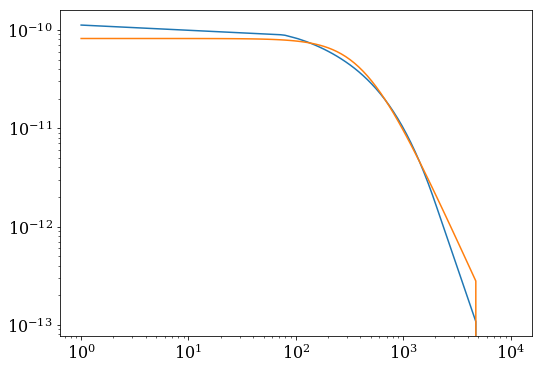

In [160]:
r,n = cluster1.get_density_crp_profile()
plt.loglog(r,n)
cluster1.density_gas_model = {'name':'beta', 'n_0':cluster1.beta_model_parameters[0]*u.cm**-3, 
                              'r_c':cluster1.beta_model_parameters[1]*u.kpc, 
                              'beta':cluster1.beta_model_parameters[2]}
cluster1.set_density_crp_isodens_scal_param()
r,n = cluster1.get_density_crp_profile()
plt.loglog(r,n)

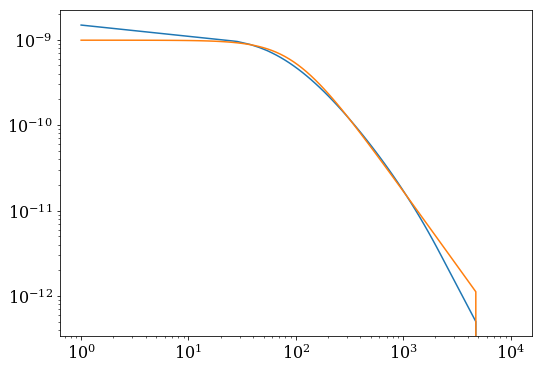

In [161]:
r,n = cluster2.get_density_crp_profile()
plt.loglog(r,n)
cluster2.density_gas_model = {'name':'beta', 'n_0':cluster2.beta_model_parameters[0]*u.cm**-3, 
                              'r_c':cluster2.beta_model_parameters[1]*u.kpc, 
                              'beta':cluster2.beta_model_parameters[2]}
cluster2.set_density_crp_isodens_scal_param()
r,n = cluster2.get_density_crp_profile()
plt.loglog(r,n)

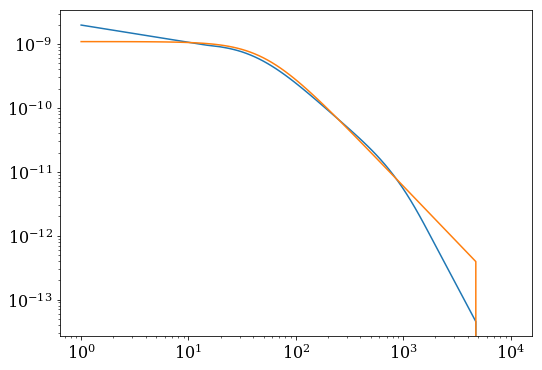

In [162]:
r,n = cluster3.get_density_crp_profile()
plt.loglog(r,n)
cluster3.density_gas_model = {'name':'beta', 'n_0':cluster3.beta_model_parameters[0]*u.cm**-3, 
                              'r_c':cluster3.beta_model_parameters[1]*u.kpc, 
                              'beta':cluster3.beta_model_parameters[2]}
cluster3.set_density_crp_isodens_scal_param()
r,n = cluster3.get_density_crp_profile()
plt.loglog(r,n)

# Profiles and spectra

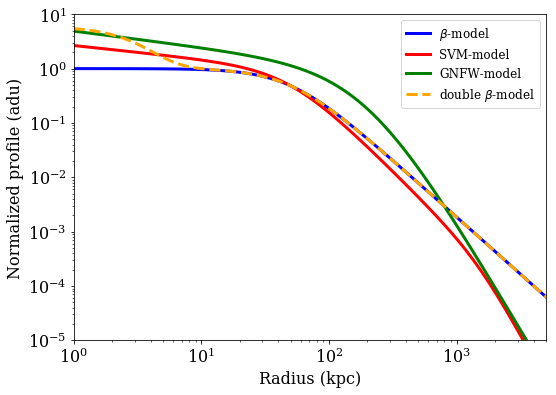

In [5]:
r = np.logspace(0,4,100)*u.kpc

p1 = cluster._get_generic_profile(r, {'name':'beta', 'n_0':1.0*u.cm**-3, 'r_c':50*u.kpc, 'beta':0.7})
p2 = cluster._get_generic_profile(r, {'name':'SVM', 'n_0':1.0*u.cm**-3, 'r_c':50*u.kpc, 'beta':0.7, 'r_s':1500*u.kpc, 'gamma':3, 'epsilon':4.0, 'alpha':0.5})
p3 = cluster._get_generic_profile(r, {'name':'GNFW', 'P_0':1.0*u.cm**-3, 'r_p':200*u.kpc, 'a':1.5, 'b':4, 'c':0.3})
p4 = cluster._get_generic_profile(r, {'name':'doublebeta', 'n_01':1.0*u.cm**-3, 'r_c1':50*u.kpc, 'beta1':0.7, 'n_02':5.0*u.cm**-3, 'r_c2':5*u.kpc, 'beta2':2.0})

plt.figure(figsize=(8,6))
plt.loglog(r, p1, label='$\\beta$-model', linewidth=3, color='blue')
plt.loglog(r, p2, label='SVM-model', linewidth=3, color='red')
plt.loglog(r, p3, label='GNFW-model', linewidth=3, color='green')
plt.loglog(r, p4, label='double $\\beta$-model', linewidth=3, linestyle='--', color='orange')
plt.xlabel('Radius (kpc)')
plt.ylabel('Normalized profile (adu)')
plt.xlim(1, 5e3)
plt.ylim(1e-5, 1e1)
plt.legend()
plt.savefig(figdir+'/profiles.pdf')

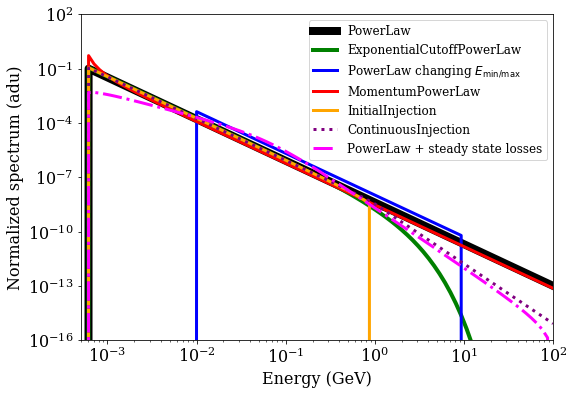

In [6]:
E = np.logspace(-4,2,100)*u.GeV

ctmp = copy.deepcopy(cluster)
ctmp.Eemin = const.m_e*const.c**2+100*u.keV
ctmp.Eemax = 100*u.GeV
ctmp.spectrum_cre1_model = {'name':'PowerLaw', 'Index':2.3}
ctmp.cre1_loss_model = 'None'
s1 = ctmp.get_cre1_spectrum(E)[1]
norm = 10*np.amax(s1)
s1 = s1/norm

ctmp = copy.deepcopy(cluster)
ctmp.Eemin = const.m_e*const.c**2+100*u.keV
ctmp.Eemax = 100*u.GeV
ctmp.spectrum_cre1_model = {'name':'ExponentialCutoffPowerLaw', 'Index':2.3, 'CutoffEnergy':1*u.GeV}
ctmp.cre1_loss_model = 'None'
s2 = ctmp.get_cre1_spectrum(E)[1]
s2 = s2/norm

ctmp = copy.deepcopy(cluster)
ctmp.Eemin=10*u.MeV
ctmp.Eemax=10*u.GeV
ctmp.spectrum_cre1_model = {'name':'PowerLaw', 'Index':2.3}
ctmp.cre1_loss_model = 'None'
s3 = ctmp.get_cre1_spectrum(E)[1]
s3 = s3/norm

ctmp = copy.deepcopy(cluster)
ctmp.Eemin = const.m_e*const.c**2+100*u.keV
ctmp.Eemax = 100*u.GeV
ctmp.spectrum_cre1_model = {'name':'MomentumPowerLaw', 'Index':2.3, 'Mass':const.m_e*const.c**2}
ctmp.cre1_loss_model = 'None'
s4 = ctmp.get_cre1_spectrum(E)[1]
s4 = s4/norm

ctmp = copy.deepcopy(cluster)
ctmp.Eemin = const.m_e*const.c**2+100*u.keV
ctmp.Eemax = 100*u.GeV
ctmp.spectrum_cre1_model = {'name':'InitialInjection', 'Index':2.3, 'BreakEnergy':1*u.GeV}
ctmp.cre1_loss_model = 'None'
s5 = ctmp.get_cre1_spectrum(E)[1]
s5 = s5/norm

ctmp = copy.deepcopy(cluster)
ctmp.Eemin = const.m_e*const.c**2+100*u.keV
ctmp.Eemax = 100*u.GeV
ctmp.spectrum_cre1_model = {'name':'ContinuousInjection', 'Index':2.3, 'BreakEnergy':1*u.GeV}
ctmp.cre1_loss_model = 'None'
s6 = ctmp.get_cre1_spectrum(E)[1]
s6 = s6/norm

ctmp = copy.deepcopy(cluster)
ctmp.Npt_per_decade_integ = 100
ctmp.cre1_loss_model = 'Steady'
ctmp.Eemin = const.m_e*const.c**2+100*u.keV
ctmp.Eemax = 100*u.GeV
ctmp.spectrum_cre1_model = {'name':'PowerLaw', 'Index':2.3}
s7 = ctmp.get_cre1_spectrum(E)[1]
s7 = s7/norm

plt.figure(figsize=(8,6))
plt.loglog(E, s1, label='PowerLaw', linewidth=8, color='k')
plt.loglog(E, s2, label='ExponentialCutoffPowerLaw', linewidth=4, linestyle='-', color='green')
plt.loglog(E, s3, label=r'PowerLaw changing $E_{\rm min/max}$', linewidth=3, color='blue')
plt.loglog(E, s4, label='MomentumPowerLaw', linewidth=3, linestyle='-', color='red')
plt.loglog(E, s5, label='InitialInjection', linewidth=3, linestyle='-', color='orange')
plt.loglog(E, s6, label='ContinuousInjection', linewidth=3, linestyle=':', color='purple')
plt.loglog(E, s7, label='PowerLaw + steady state losses', linewidth=3, linestyle='-.', color='magenta')
plt.xlabel('Energy (GeV)')
plt.ylabel('Normalized spectrum (adu)')
plt.xlim(5e-4, 1e2)
plt.ylim(1e-16, 100)
plt.legend(loc='upper right')
plt.savefig(figdir+'/spectra.pdf')

# Thermodynamics

/Users/adam/Project/anaconda3/envs/fermi/lib/python2.7/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


(0.21330061679555268, <Quantity 7.e+14 solMass>)


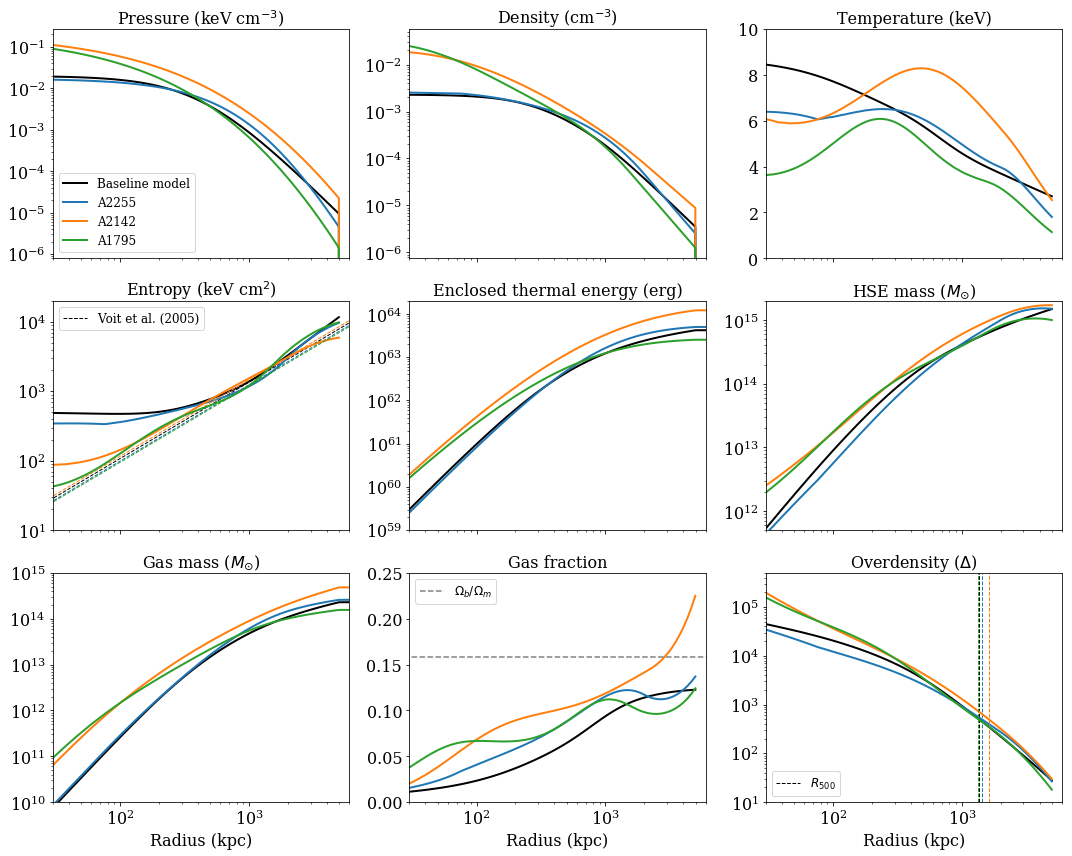

In [7]:
r = np.logspace(1,4,100)*u.kpc

colcycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
f_b = cluster.cosmo.Ob0 / cluster.cosmo.Om0

fig, ax = plt.subplots(3,3,figsize=(15,12), sharex=True)
#----- Pressure
Pe  = cluster.get_pressure_gas_profile(r)[1]
ax[0,0].loglog(r, Pe, linewidth=2, color='k', label='Baseline model')
for c in cluster_list:
    Pe  = c.get_pressure_gas_profile(r)[1]
    ax[0,0].loglog(r, Pe, linewidth=2, label=c.name)
ax[0,0].set_title('Pressure (keV cm$^{-3}$)')
ax[0,0].legend()

#----- Density
ne  = cluster.get_density_gas_profile(r)[1]
ax[0,1].loglog(r, ne, linewidth=2, color='k')
for c in cluster_list:
    ne  = c.get_density_gas_profile(r)[1]
    ax[0,1].loglog(r, ne, linewidth=2)
ax[0,1].set_title('Density (cm$^{-3}$)')

#----- Temperature
T   = cluster.get_temperature_gas_profile(r)[1]
ax[0,2].plot(r, T, linewidth=2, color='k')
for c in cluster_list:
    T   = c.get_temperature_gas_profile(r)[1]
    ax[0,2].plot(r, T, linewidth=2)
ax[0,2].set_title('Temperature (keV)')
ax[0,2].set_ylim(0,10)

#----- Entropy
K   = cluster.get_entropy_gas_profile(r)[1]
k500 = 106.0 * (cluster.M500.to_value('Msun')/1e14*cluster.cosmo.H0.value/70.0)**(2.0/3.0) * (1.0/f_b)**(2.0/3.0) * cluster.cosmo.efunc(cluster.redshift)**(-2./3.0) * (cluster.cosmo.H0.value/70.0)**(-4.0/3.0)
blk = 1.42*k500*(r.to_value('kpc') / cluster.R500.to_value('kpc'))**1.1
ax[1,0].loglog(r, K, linewidth=2, color='k')
ax[1,0].loglog(r, blk, linewidth=1, linestyle='--', color='k', label='Voit et al. (2005)')
i=0
for c in cluster_list:
    K   = c.get_entropy_gas_profile(r)[1]
    k500 = 106.0 * (c.M500.to_value('Msun')/1e14*c.cosmo.H0.value/70.0)**(2.0/3.0) * (1.0/f_b)**(2.0/3.0) * c.cosmo.efunc(c.redshift)**(-2./3.0) * (c.cosmo.H0.value/70.0)**(-4.0/3.0)
    blk = 1.42*k500*(r.to_value('kpc') / c.R500.to_value('kpc'))**1.1
    ax[1,0].loglog(r, K, linewidth=2)
    ax[1,0].loglog(r, blk, linewidth=1, linestyle='--', color=colcycle[i])
    i=i+1
ax[1,0].set_title('Entropy (keV cm$^{2}$)')
ax[1,0].set_ylim(1e1, 2e4)
ax[1,0].legend()

#----- Thermal energy
Uth = cluster.get_thermal_energy_profile(r)[1]
ax[1,1].loglog(r, Uth, linewidth=2, color='k')
for c in cluster_list:
    Uth = c.get_thermal_energy_profile(r)[1]
    ax[1,1].loglog(r, Uth, linewidth=2)
ax[1,1].set_title('Enclosed thermal energy (erg)')
ax[1,1].set_ylim(1e59,2e64)

#----- Hydrostatic mass
Mhse = cluster.get_hse_mass_profile(r)[1]
ax[1,2].loglog(r, Mhse, linewidth=2, color='k')
for c in cluster_list:
    Mhse = c.get_hse_mass_profile(r)[1]
    ax[1,2].loglog(r, Mhse, linewidth=2)
ax[1,2].set_title('HSE mass ($M_{\odot}$)')
ax[1,2].set_ylim(5e11,2e15)

#----- Gas mass
Mgas = cluster.get_gas_mass_profile(r)[1]
ax[2,0].loglog(r, Mgas, linewidth=2, color='k')
for c in cluster_list:
    Mgas = c.get_gas_mass_profile(r)[1]
    ax[2,0].loglog(r, Mgas, linewidth=2)
ax[2,0].set_title('Gas mass ($M_{\odot}$)')
ax[2,0].set_ylim(1e10,1e15)

#----- Gas fraction
fgas = cluster.get_fgas_profile(r)[1]
ax[2,1].plot(r, fgas, linewidth=2, color='k')
for c in cluster_list:
    fgas = c.get_fgas_profile(r)[1]
    ax[2,1].plot(r, fgas, linewidth=2)
ax[2,1].plot([np.amin(r.value), np.amax(r.value)], [f_b, f_b], linestyle='--', label='$\\Omega_b / \\Omega_m$', color='grey')
ax[2,1].set_title('Gas fraction')
ax[2,1].set_ylim(0,0.25)
ax[2,1].legend()

#----- Overdensity
od   = cluster.get_overdensity_contrast_profile(r)[1]
ax[2,2].loglog(r, od, linewidth=2, color='k')
R500, M500 = cluster.get_mdelta_from_profile()
ax[2,2].axvline(R500.to_value('kpc'), linewidth=1, linestyle='--', label='$R_{500}$', color='k')
i=0
for c in cluster_list:
    od   = c.get_overdensity_contrast_profile(r)[1]
    ax[2,2].loglog(r, od, linewidth=2)
    R500, M500 = c.get_mdelta_from_profile()
    ax[2,2].axvline(R500.to_value('kpc'), linewidth=1, linestyle='--', color=colcycle[i])
    i=i+1
ax[2,2].set_title('Overdensity ($\\Delta$)')
ax[2,2].legend()
ax[2,2].set_ylim(10,5e5)

ax[2,0].set_xlabel('Radius (kpc)')
ax[2,1].set_xlabel('Radius (kpc)')
ax[2,2].set_xlabel('Radius (kpc)')
ax[2,2].set_xlim(30,6000)

fig.subplots_adjust(wspace=None, hspace=None)
plt.tight_layout()
plt.savefig(figdir+'/thermodynamic_profiles.pdf')

#---------- Check the HSE bias
cluster.set_hsebias_from_m500_and_mhse()
print(cluster.hse_bias, cluster.M500)

# Non-thermal properties

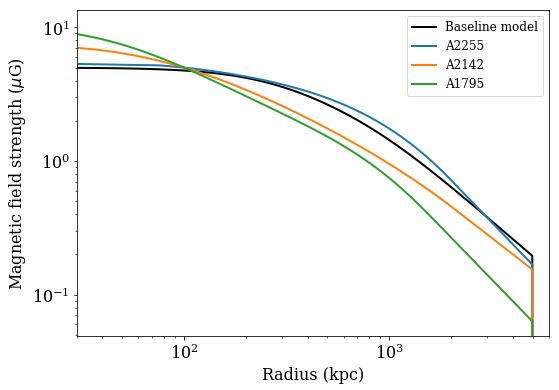

In [8]:
r = np.logspace(1,4,100)*u.kpc

plt.figure(0,figsize=(8,6))
B  = cluster.get_magfield_profile(r)[1]
plt.loglog(r, B, linewidth=2, color='k', label='Baseline model')
for c in cluster_list:
    B  = c.get_magfield_profile(r)[1]
    plt.loglog(r, B, linewidth=2, label=c.name)
plt.ylabel('Magnetic field strength ($\\mu$G)')
plt.xlabel('Radius (kpc)')
plt.xlim(30,6000)
plt.legend()
plt.savefig(figdir+'/magnetic_field_profile.pdf')

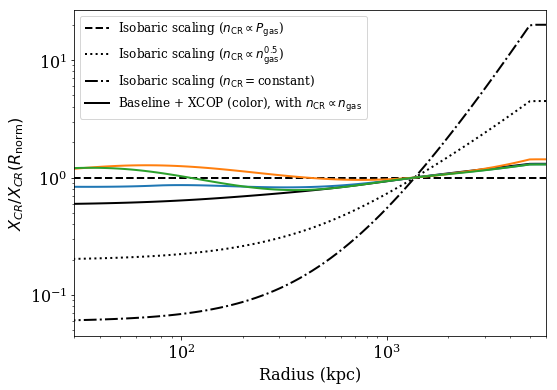

In [9]:
r = np.logspace(1,4,100)*u.kpc

plt.figure(0,figsize=(8,6))

ctmp = copy.deepcopy(cluster)    
ctmp.set_density_crp_isobaric_scal_param(scal=1)
Xcrp  = ctmp.get_crp_to_thermal_energy_profile(r)[1]
Xcrp_N  = ctmp.get_crp_to_thermal_energy_profile(cluster.X_crp_E['R_norm'])[1]
plt.plot(r, Xcrp/Xcrp_N, linewidth=2, color='k', linestyle='--', label=r'Isobaric scaling ($n_{\rm CR} \propto P_{\rm gas}$)')

ctmp.set_density_crp_isodens_scal_param(scal=0.5)
Xcrp  = ctmp.get_crp_to_thermal_energy_profile(r)[1]
Xcrp_N  = ctmp.get_crp_to_thermal_energy_profile(cluster.X_crp_E['R_norm'])[1]
plt.plot(r, Xcrp/Xcrp_N, linewidth=2, color='k', linestyle=':', label=r'Isobaric scaling ($n_{\rm CR} \propto n_{\rm gas}^{0.5}$)')

ctmp.set_density_crp_isobaric_scal_param(scal=0)
Xcrp  = ctmp.get_crp_to_thermal_energy_profile(r)[1]
Xcrp_N  = ctmp.get_crp_to_thermal_energy_profile(cluster.X_crp_E['R_norm'])[1]
plt.plot(r, Xcrp/Xcrp_N, linewidth=2, color='k', linestyle='-.', label=r'Isobaric scaling ($n_{\rm CR} = $constant)')

Xcrp  = cluster.get_crp_to_thermal_energy_profile(r)[1]
Xcrp_N  = ctmp.get_crp_to_thermal_energy_profile(cluster.X_crp_E['R_norm'])[1]
plt.plot(r, Xcrp/Xcrp_N, linewidth=2, color='k', label=r'Baseline + XCOP (color), with $n_{\rm CR} \propto n_{\rm gas}$')

for c in cluster_list:
    Xcrp  = c.get_crp_to_thermal_energy_profile(r)[1]
    Xcrp_N  = c.get_crp_to_thermal_energy_profile(cluster.X_crp_E['R_norm'])[1]
    plt.plot(r, Xcrp/Xcrp_N, linewidth=2)#, label=c.name+r' ($n_{\rm CR} \propto n_{\rm gas}$)')
plt.ylabel(r'$X_{CR} / X_{CR}(R_{\rm norm})$')
plt.xlabel('Radius (kpc)')
plt.xscale('log')
plt.yscale('log')
plt.xlim(30,6000)
plt.legend()
plt.savefig(figdir+'/Xcr_profile.pdf')

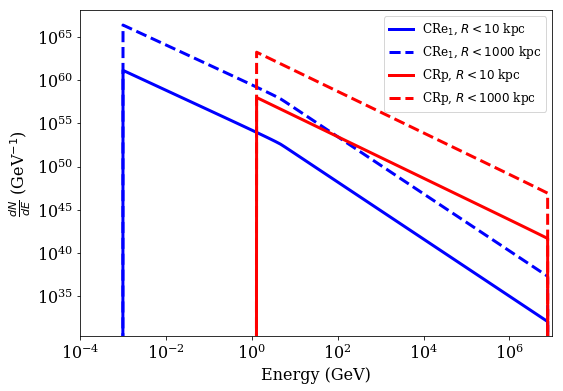

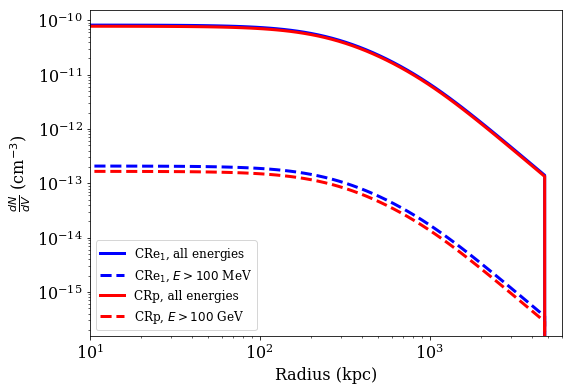

In [10]:
e = np.logspace(-4,7,100)*u.GeV
r = np.logspace(0,4,100)*u.kpc

ncre1_10 = cluster.get_cre1_spectrum(e, Rmax=10*u.kpc)[1]
ncrp_10  = cluster.get_crp_spectrum(e, Rmax=10*u.kpc)[1]
ncre1_1000 = cluster.get_cre1_spectrum(e, Rmax=1000*u.kpc)[1]
ncrp_1000  = cluster.get_crp_spectrum(e, Rmax=1000*u.kpc)[1]

plt.figure(0, figsize=(8,6))
plt.loglog(e, ncre1_10.to_value('GeV-1'), linewidth=3, color='blue', label='CRe$_1$, $R<10$ kpc')
plt.loglog(e, ncre1_1000.to_value('GeV-1'), linewidth=3, color='blue', linestyle='--', label='CRe$_1$, $R<1000$ kpc')
plt.loglog(e, ncrp_10.to_value('GeV-1'), linewidth=3, color='red', label='CRp, $R<10$ kpc')
plt.loglog(e, ncrp_1000.to_value('GeV-1'), linewidth=3, color='red', linestyle='--', label='CRp, $R<1000$ kpc')
plt.xlabel('Energy (GeV)')
plt.ylabel(r'$\frac{dN}{dE}$ (GeV$^{-1}$)')
plt.xlim(1e-4,1e7)
plt.legend()
plt.savefig(figdir+'/nonthermal_spectra.pdf')

ncre1_1 = cluster.get_density_cre1_profile(r, Emin=const.m_e*const.c**2)[1]
ncre1_2  = cluster.get_density_cre1_profile(r, Emin=100*u.MeV)[1]
ncrp_1 = cluster.get_density_crp_profile(r, Emin=const.m_p*const.c**2)[1]
ncrp_2  = cluster.get_density_crp_profile(r, Emin=100*u.GeV)[1]

plt.figure(1, figsize=(8,6))
plt.loglog(r, ncre1_1.to_value('cm-3'), linewidth=3, color='blue', label='CRe$_1$, all energies')
plt.loglog(r, ncre1_2.to_value('cm-3'), linewidth=3, color='blue', linestyle='--', label='CRe$_1$, $E>100$ MeV')
plt.loglog(r, ncrp_1.to_value('cm-3'), linewidth=3, color='red', label='CRp, all energies')
plt.loglog(r, ncrp_2.to_value('cm-3'), linewidth=3, color='red', linestyle='--', label='CRp, $E>100$ GeV')
plt.xlabel('Radius (kpc)')
plt.ylabel(r'$\frac{dN}{dV}$ (cm$^{-3}$)')
plt.xlim(10,6000)
plt.legend(loc='lower left')
plt.savefig(figdir+'/nonthermal_profile.pdf')

# Production rate of particles

/Users/adam/Project/anaconda3/envs/fermi/lib/python2.7/site-packages/astropy/units/quantity.py:641: RuntimeWarning: invalid value encountered in true_divide
  *arrays, **kwargs)


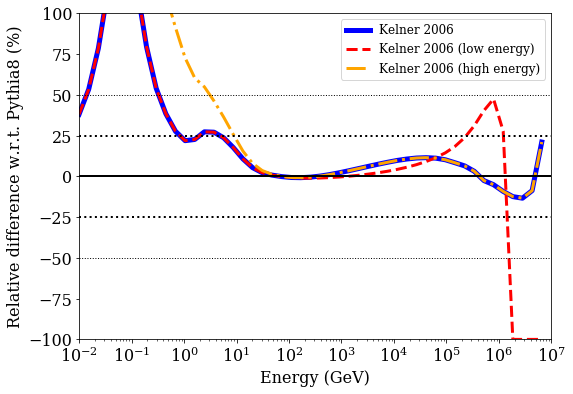

In [11]:
# Comparison between Kelner and Kafexhiu
e = np.logspace(-2,7,50)*u.GeV
ctmp = copy.deepcopy(cluster)
r = 100*u.kpc
ctmp.abundance = 0.0
ctmp.helium_mass_fraction = 0.0

dNdEdVdt1 = ctmp.get_rate_gamma(energy=e,radius=r, model='Kafexhiu2014')[:,0]
dNdEdVdt2 = ctmp.get_rate_gamma(energy=e,radius=r, model='Kelner2006', limit='mixed')[:,0]
dNdEdVdt3 = ctmp.get_rate_gamma(energy=e,radius=r, model='Kelner2006', limit='lowE')[:,0]
dNdEdVdt4 = ctmp.get_rate_gamma(energy=e,radius=r, model='Kelner2006', limit='highE')[:,0]

plt.figure(figsize=(8,6))
plt.plot(e, 100*(dNdEdVdt2-dNdEdVdt1)/dNdEdVdt1, label='Kelner 2006', linewidth=5, color='blue')
plt.plot(e, 100*(dNdEdVdt3-dNdEdVdt1)/dNdEdVdt1, label='Kelner 2006 (low energy)', linewidth=3, linestyle='--', color='red')
plt.plot(e, 100*(dNdEdVdt4-dNdEdVdt1)/dNdEdVdt1, label='Kelner 2006 (high energy)', linewidth=3, linestyle='-.', color='orange')
plt.plot(e, e.value*0, linewidth=2, linestyle='-', color='k')
plt.plot(e, e.value*0+25, linewidth=2, linestyle=':', color='k')
plt.plot(e, e.value*0-25, linewidth=2, linestyle=':', color='k')
plt.plot(e, e.value*0+50, linewidth=1, linestyle=':', color='k')
plt.plot(e, e.value*0-50, linewidth=1, linestyle=':', color='k')
plt.xlabel('Energy (GeV)')
plt.ylabel('Relative difference w.r.t. Pythia8 (%)')
plt.xscale('log')
plt.xlim(1e-2, 1e7)
plt.ylim(-100,100)
plt.legend()
plt.savefig(figdir+'/prodrate1.pdf')

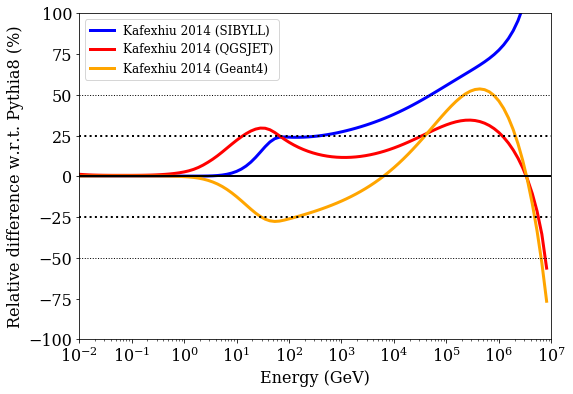

In [12]:
# Impact of the particle physics data
e = np.logspace(-2,7,100)*u.GeV
ctmp = copy.deepcopy(cluster)
r = 100*u.kpc

ctmp.pp_interaction_model = 'Pythia8'
dNdEdVdt1 = ctmp.get_rate_gamma(energy=e,radius=r)[:,0]
ctmp.pp_interaction_model = 'SIBYLL'
dNdEdVdt2 = ctmp.get_rate_gamma(energy=e,radius=r)[:,0]
ctmp.pp_interaction_model = 'QGSJET'
dNdEdVdt3 = ctmp.get_rate_gamma(energy=e,radius=r)[:,0]
ctmp.pp_interaction_model = 'Geant4'
dNdEdVdt4 = ctmp.get_rate_gamma(energy=e,radius=r)[:,0]

plt.figure(figsize=(8,6))
plt.plot(e, 100*(dNdEdVdt2-dNdEdVdt1)/dNdEdVdt1, label='Kafexhiu 2014 (SIBYLL)', linewidth=3, color='blue')
plt.plot(e, 100*(dNdEdVdt3-dNdEdVdt1)/dNdEdVdt1, label='Kafexhiu 2014 (QGSJET)', linewidth=3, color='red')
plt.plot(e, 100*(dNdEdVdt4-dNdEdVdt1)/dNdEdVdt1, label='Kafexhiu 2014 (Geant4)', linewidth=3, color='orange')
plt.plot(e, e.value*0, linewidth=2, linestyle='-', color='k')
plt.plot(e, e.value*0+25, linewidth=2, linestyle=':', color='k')
plt.plot(e, e.value*0-25, linewidth=2, linestyle=':', color='k')
plt.plot(e, e.value*0+50, linewidth=1, linestyle=':', color='k')
plt.plot(e, e.value*0-50, linewidth=1, linestyle=':', color='k')
plt.xlabel('Energy (GeV)')
plt.ylabel('Relative difference w.r.t. Pythia8 (%)')
plt.xscale('log')
plt.xlim(1e-2, 1e7)
plt.ylim(-100,100)
plt.legend()
plt.savefig(figdir+'/prodrate2.pdf')

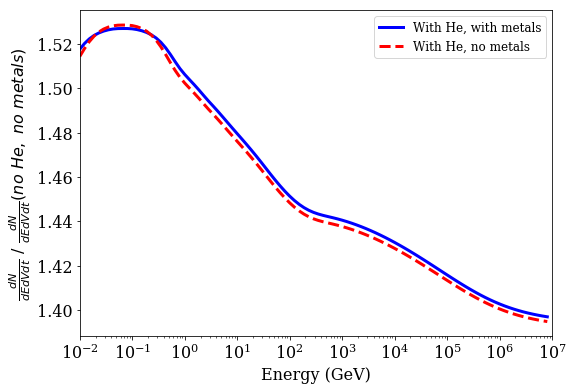

In [13]:
# Impact of the ICM metals
e = np.logspace(-2,7,100)*u.GeV
ctmp = copy.deepcopy(cluster)
r = 100*u.kpc

ctmp.abundance = 1.0
ctmp.helium_mass_fraction = 0.27
dNdEdVdt1 = ctmp.get_rate_gamma(energy=e,radius=r)[:,0]
ctmp.abundance = 0.0
ctmp.helium_mass_fraction = 0.27
dNdEdVdt2 = ctmp.get_rate_gamma(energy=e,radius=r)[:,0]
ctmp.abundance = 0.0
ctmp.helium_mass_fraction = 0.0
dNdEdVdt3 = ctmp.get_rate_gamma(energy=e,radius=r)[:,0]

plt.figure(figsize=(8,6))
plt.plot(e, dNdEdVdt1/dNdEdVdt3, label='With He, with metals', linewidth=3, color='blue')
plt.plot(e, dNdEdVdt2/dNdEdVdt3, label='With He, no metals', linewidth=3, color='red', linestyle='--')
plt.xlabel('Energy (GeV)')
plt.ylabel(r'$\frac{dN}{dEdVdt} \ / \ \frac{dN}{dEdVdt} (no \ He, \ no \ metals)$')
plt.xscale('log')
plt.xlim(1e-2, 1e7)
#plt.ylim(0.5,1.1)
plt.legend()
plt.savefig(figdir+'/prodrate3.pdf')

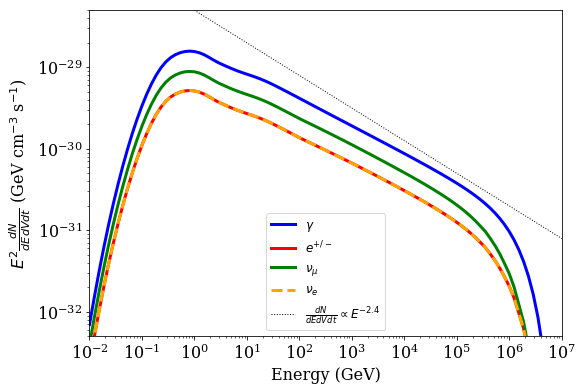

In [14]:
# Final result
e = np.logspace(-2,7,100)*u.GeV
r = 100*u.kpc

dNgdEdVdt = cluster.get_rate_gamma(energy=e,radius=r)[:,0]
dNedEdVdt = cluster.get_rate_cre2(energy=e,radius=r)[:,0]
dNnumudEdVdt = cluster.get_rate_neutrino(energy=e,radius=r,flavor='numu')[:,0]
dNnuedEdVdt = cluster.get_rate_neutrino(energy=e,radius=r,flavor='nue')[:,0]

plt.figure(figsize=(8,6))
plt.loglog(e, (e**2*dNgdEdVdt).to('GeV cm-3 s-1'), label='$\\gamma$', linewidth=3, color='blue')
plt.loglog(e, (e**2*dNedEdVdt).to('GeV cm-3 s-1'), label='$e^{+/-}$', linewidth=3, color='red')
plt.loglog(e, (e**2*dNnumudEdVdt).to('GeV cm-3 s-1'), label='$\\nu_{\\mu}$', linewidth=3, color='green')
plt.loglog(e, (e**2*dNnuedEdVdt).to('GeV cm-3 s-1'), label='$\\nu_{e}$', linewidth=3, linestyle='--', color='orange')
plt.loglog(e, 5e-29*(e**2*e**-cluster.spectrum_crp_model['Index']), label=r'$\frac{dN}{dEdVdt}\propto E^{-'+str(cluster.spectrum_crp_model['Index'])+'}$', linewidth=1, linestyle=':', color='k')
plt.xlabel('Energy (GeV)')
plt.ylabel(r'$E^2 \frac{dN}{dEdVdt}$ (GeV cm$^{-3}$ s$^{-1}$)')
plt.xlim(1e-2, 1e7)
plt.ylim(5e-33, 5e-29)
plt.legend()
plt.savefig(figdir+'/prodrate4.pdf')

# Electron energy loss

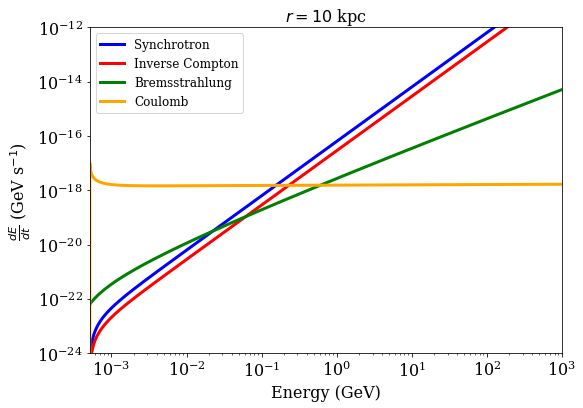

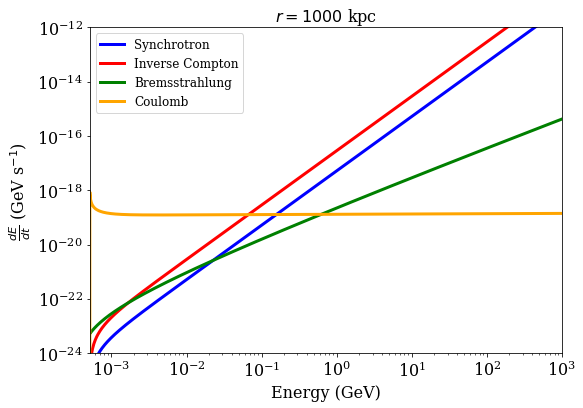

In [5]:
energy = np.logspace(-4, 5, 1000)*u.GeV

# ----- 10 kpc
B = (cluster.get_magfield_profile(10*u.kpc)[1])[0]
n_e = (cluster.get_density_gas_profile(10*u.kpc)[1])[0]

dEdt_sync = cel.dEdt_sync(energy, B)
dEdt_ic = cel.dEdt_ic(energy, cluster.redshift)
dEdt_brem = cel.dEdt_brem(energy, n_e)
dEdt_coul = cel.dEdt_coul(energy, n_e)

plt.figure(0, figsize=(8,6))
plt.loglog(energy, dEdt_sync, label='Synchrotron', linewidth=3, color='blue')
plt.loglog(energy, dEdt_ic, label='Inverse Compton', linewidth=3, color='red')
plt.loglog(energy, dEdt_brem, label='Bremsstrahlung', linewidth=3, color='green')
plt.loglog(energy, dEdt_coul, label='Coulomb', linewidth=3, color='orange')
plt.xlabel('Energy (GeV)')
plt.ylabel(r'$\frac{dE}{dt}$ (GeV s$^{-1}$)')
plt.title('$r = 10$ kpc')
plt.xlim((const.m_e*const.c**2).to_value('GeV'), 1e3)
plt.ylim(1e-24, 1e-12)
plt.legend()
plt.savefig(figdir+'/loss1.pdf')

# ----- 1000 kpc
B = (cluster.get_magfield_profile(1000*u.kpc)[1])[0]
n_e = (cluster.get_density_gas_profile(1000*u.kpc)[1])[0]

dEdt_sync = cel.dEdt_sync(energy, B)
dEdt_ic = cel.dEdt_ic(energy, cluster.redshift)
dEdt_brem = cel.dEdt_brem(energy, n_e)
dEdt_coul = cel.dEdt_coul(energy, n_e)

plt.figure(1, figsize=(8,6))
plt.loglog(energy, dEdt_sync, label='Synchrotron', linewidth=3, color='blue')
plt.loglog(energy, dEdt_ic, label='Inverse Compton', linewidth=3, color='red')
plt.loglog(energy, dEdt_brem, label='Bremsstrahlung', linewidth=3, color='green')
plt.loglog(energy, dEdt_coul, label='Coulomb', linewidth=3, color='orange')
plt.xlabel('Energy (GeV)')
plt.ylabel(r'$\frac{dE}{dt}$ (GeV s$^{-1}$)')
plt.title('$r = 1000$ kpc')
plt.xlim((const.m_e*const.c**2).to_value('GeV'), 1e3)
plt.ylim(1e-24, 1e-12)
plt.legend()
plt.savefig(figdir+'/loss2.pdf')

# Spectrum of CRe2

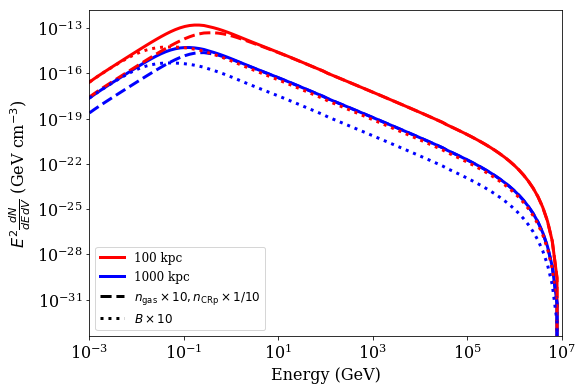

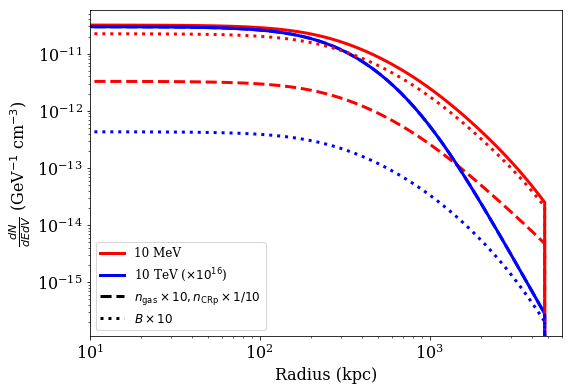

In [16]:
e = np.logspace(-3,7,100)*u.GeV
r = np.logspace(0,4,100)*u.kpc

#---------- Spectrum
plt.figure(0, figsize=(8,6))
ncre2_100 = cluster.get_cre2_2d(e,100*u.kpc)[:,0]
ncre2_1000 = cluster.get_cre2_2d(e,1000*u.kpc)[:,0]
plt.loglog(e, e**2*ncre2_100.to_value('GeV-1 cm-3'), linewidth=3, label='100 kpc', color='red')
plt.loglog(e, e**2*ncre2_1000.to_value('GeV-1 cm-3'), linewidth=3, label='1000 kpc', color='blue')
ctmp = copy.deepcopy(cluster)
ctmp.density_gas_model['n_0'] *= 10
ctmp.X_crp_E['X'] *= 0.1
ncre2_100 = ctmp.get_cre2_2d(e,100*u.kpc)[:,0]
ncre2_1000 = ctmp.get_cre2_2d(e,1000*u.kpc)[:,0]
plt.loglog(e, e**2*ncre2_100.to_value('GeV-1 cm-3'), linewidth=3, color='red',linestyle='--', label=r'$n_{\rm gas} \times 10, n_{\rm CRp} \times 1/10$')
plt.loglog(e, e**2*ncre2_1000.to_value('GeV-1 cm-3'), linewidth=3, color='blue',linestyle='--')
ctmp = copy.deepcopy(cluster)
ctmp.magfield_model['n_0'] *= 10
ncre2_100 = ctmp.get_cre2_2d(e,100*u.kpc)[:,0]
ncre2_1000 = ctmp.get_cre2_2d(e,1000*u.kpc)[:,0]
plt.loglog(e, e**2*ncre2_100.to_value('GeV-1 cm-3'), linewidth=3, color='red',linestyle=':', label=r'$B \times 10$')
plt.loglog(e, e**2*ncre2_1000.to_value('GeV-1 cm-3'), linewidth=3, color='blue',linestyle=':')
plt.xlabel('Energy (GeV)')
plt.ylabel(r'$E^2 \frac{dN}{dEdV}$ (GeV cm$^{-3}$)')
plt.xlim(1e-3, 1e7)
plt.legend()
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[2].set_color('k')
leg.legendHandles[3].set_color('k')
plt.savefig(figdir+'/CRe2_spectra.pdf')

#---------- Profile
plt.figure(1, figsize=(8,6))
ncre2_10MeV = cluster.get_cre2_2d(10*u.MeV,r)[0,:]
ncre2_10TeV = cluster.get_cre2_2d(10*u.TeV, r)[0,:]
plt.loglog(r, ncre2_10MeV.to_value('GeV-1 cm-3'), linewidth=3, label='10 MeV', color='red')
plt.loglog(r, 1e16*ncre2_10TeV.to_value('GeV-1 cm-3'), linewidth=3, label='10 TeV ($\\times 10^{16}$)', color='blue')
ctmp = copy.deepcopy(cluster)
ctmp.density_gas_model['n_0'] *= 10
ctmp.X_crp_E['X'] *= 0.1
ncre2_10MeV = ctmp.get_cre2_2d(10*u.MeV,r)[0,:]
ncre2_10TeV = ctmp.get_cre2_2d(10*u.TeV, r)[0,:]
plt.loglog(r, ncre2_10MeV.to_value('GeV-1 cm-3'), linewidth=3, label=r'$n_{\rm gas} \times 10, n_{\rm CRp} \times 1/10$', color='red', linestyle='--')
plt.loglog(r, 1e16*ncre2_10TeV.to_value('GeV-1 cm-3'), linewidth=3, color='blue', linestyle='--')
ctmp = copy.deepcopy(cluster)
ctmp.magfield_model['n_0'] *= 10
ncre2_10MeV = ctmp.get_cre2_2d(10*u.MeV,r)[0,:]
ncre2_10TeV = ctmp.get_cre2_2d(10*u.TeV, r)[0,:]
plt.loglog(r, ncre2_10MeV.to_value('GeV-1 cm-3'), linewidth=3, label=r'$B \times 10$', color='red', linestyle=':')
plt.loglog(r, 1e16*ncre2_10TeV.to_value('GeV-1 cm-3'), linewidth=3, color='blue', linestyle=':')
plt.xlabel('Radius (kpc)')
plt.ylabel(r'$\frac{dN}{dEdV}$ (GeV$^{-1}$ cm$^{-3}$)')
plt.xlim(10, 6000)
plt.legend(loc='lower left')
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[2].set_color('k')
leg.legendHandles[3].set_color('k')
plt.savefig(figdir+'/CRe2_profile.pdf')

# Effect of EBL

/Users/adam/Project/anaconda3/envs/fermi/lib/python2.7/site-packages/ebltable/tau_from_model.py:302: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  RuntimeWarning)


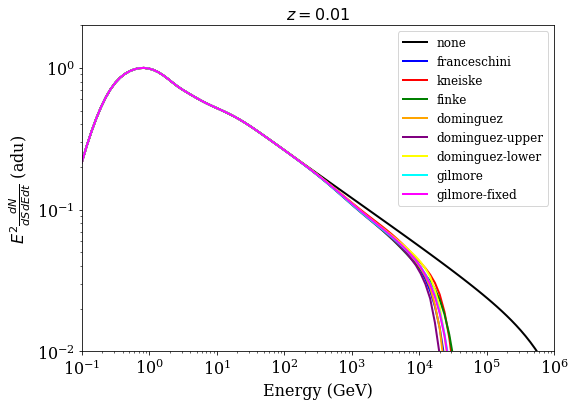

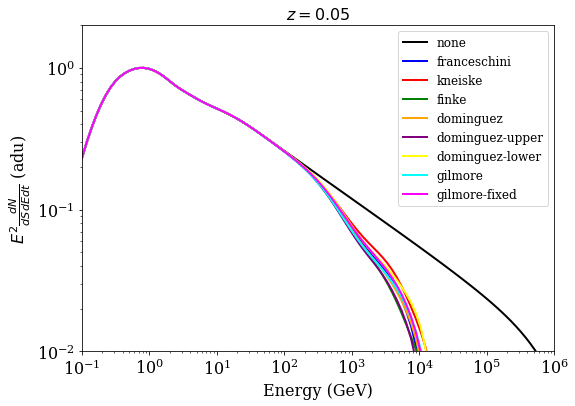

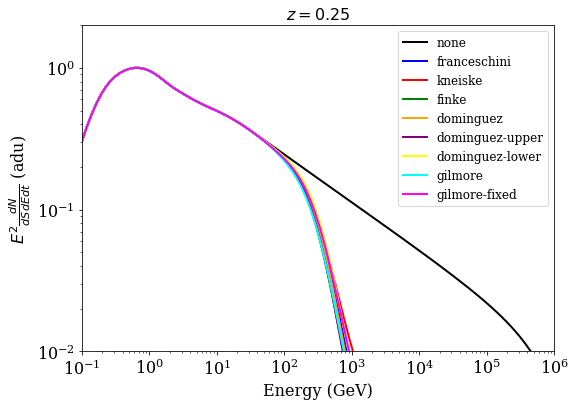

In [17]:
EBL_model = ['none', 'franceschini', 'kneiske', 'finke', 'dominguez', 'dominguez-upper', 'dominguez-lower', 'gilmore', 'gilmore-fixed']
mycolcyc  = ['k',    'blue',         'red',     'green', 'orange',    'purple',          'yellow',          'cyan',    'magenta']

energy = np.logspace(-1, 6, 100)*u.GeV
ctmp = copy.deepcopy(cluster)

plt.figure(0, figsize=(8,6))
i=0
for m in EBL_model:
    ctmp.redshift = 0.01
    ctmp.EBL_model = m
    e, S = ctmp.get_gamma_spectrum(energy)
    plt.loglog(e, e**2*S/np.amax((e**2*S).value), label=m, linewidth=2, color=mycolcyc[i])
    i = i+1
plt.xlabel('Energy (GeV)')
plt.ylabel(r'$E^2 \frac{dN}{dSdEdt}$ (adu)')
plt.title('$z = 0.01$')
plt.xlim(1e-1, 1e6)
plt.ylim(1e-2, 2)
plt.legend()
plt.savefig(figdir+'/ebl_impact1.pdf')

plt.figure(1, figsize=(8,6))
i=0
for m in EBL_model:
    ctmp.redshift = 0.05
    ctmp.EBL_model = m
    e, S = ctmp.get_gamma_spectrum(energy)
    plt.loglog(e, e**2*S/np.amax((e**2*S).value), label=m, linewidth=2, color=mycolcyc[i])
    i = i+1
plt.xlabel('Energy (GeV)')
plt.ylabel(r'$E^2 \frac{dN}{dSdEdt}$ (adu)')
plt.title('$z = 0.05$')
plt.xlim(1e-1, 1e6)
plt.ylim(1e-2, 2)
plt.legend()
plt.savefig(figdir+'/ebl_impact2.pdf')

plt.figure(2, figsize=(8,6))
i=0
for m in EBL_model:
    ctmp.redshift = 0.25
    ctmp.EBL_model = m
    e, S = ctmp.get_gamma_spectrum(energy)
    plt.loglog(e, e**2*S/np.amax((e**2*S).value), label=m, linewidth=2, color=mycolcyc[i])
    i = i+1
plt.xlabel('Energy (GeV)')
plt.ylabel(r'$E^2 \frac{dN}{dSdEdt}$ (adu)')
plt.title('$z = 0.25$')
plt.xlim(1e-1, 1e6)
plt.ylim(1e-2, 2)
plt.legend()
plt.savefig(figdir+'/ebl_impact3.pdf')

# Observables

Flux:
('R500, sph', <Quantity 0.29150947 1 / (cm2 s)>)
('R500, cyl', <Quantity 0.30482598 1 / (cm2 s)>)
('Rtrunc, sph', <Quantity 0.33104173 1 / (cm2 s)>)
('Rtrunc, cyl', <Quantity 0.33015942 1 / (cm2 s)>)


/Users/adam/Project/anaconda3/envs/fermi/lib/python2.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log10


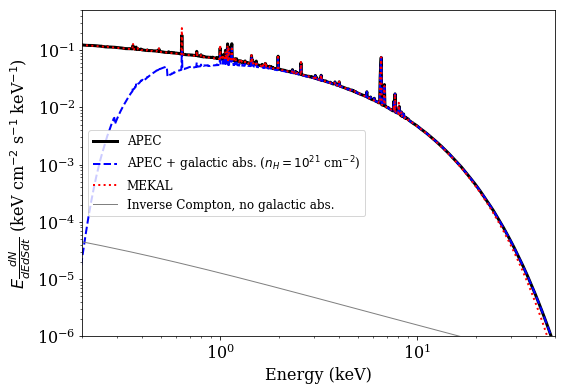

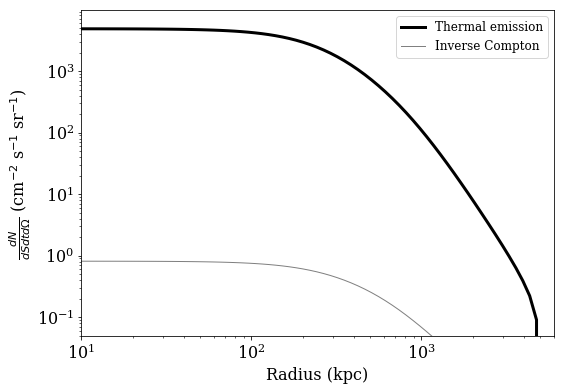

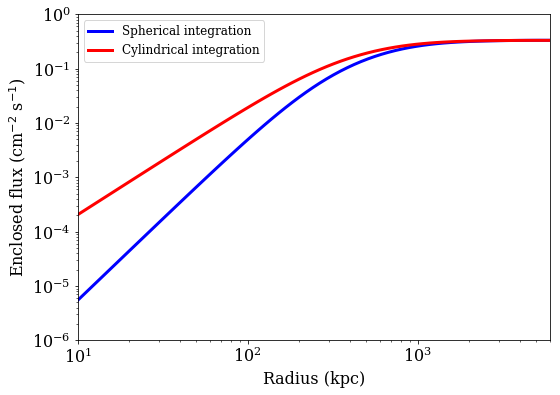

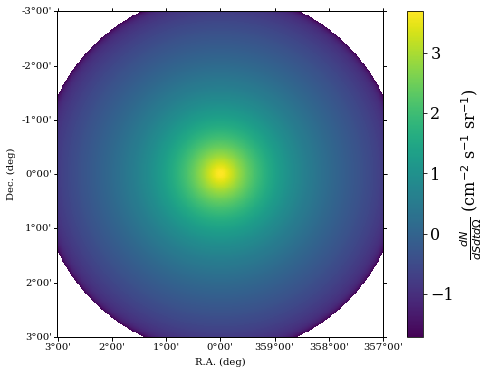

In [18]:
#---------- X-ray
E = np.linspace(0.1,50,1000)*u.keV
r = np.logspace(0,4,100)*u.kpc

#----- Spectrum
ctmp = copy.deepcopy(cluster)
plt.figure(0, figsize=(8,6))
e1, X1 = ctmp.get_xray_spectrum(E, model='APEC', nH=0.0*u.cm**-2, output_type='S')
plt.loglog(e1, X1.to_value('keV keV-1 s-1 cm-2'), linewidth=3, label='APEC', color='k')
e3, X3 = ctmp.get_xray_spectrum(E, model='APEC', nH=1.0*1e21*u.cm**-2, output_type='S')
plt.loglog(e3, X3.to_value('keV keV-1 s-1 cm-2'), linewidth=1, linestyle='--', label='APEC + galactic abs. ($n_{H} = 10^{21}$ cm$^{-2}$)', color='blue')
e2, X2 = ctmp.get_xray_spectrum(E, model='MEKAL', nH=0.0*u.cm**-2, output_type='S')
plt.loglog(e2, X2.to_value('keV keV-1 s-1 cm-2'), linewidth=1, linestyle=':', label='MEKAL', color='red')
E_ic, S_ic = ctmp.get_ic_spectrum(E)
plt.loglog(E_ic, (E*S_ic).to_value('keV cm-2 s-1 keV-1'), linewidth=1, label='Inverse Compton, no galactic abs.', color='grey')
plt.xlabel('Energy (keV)')
plt.ylabel(r'$E \frac{dN}{dEdSdt}$ (keV cm$^{-2}$ s$^{-1}$ keV$^{-1}$)')
plt.ylim(1e-6,5e-1)
plt.xlim(0.2, 50)
plt.legend()
plt.savefig(figdir+'/xray_spectra.pdf')

#----- Profile
ctmp = copy.deepcopy(cluster)
ctmp.make_xspec_table(Emin=0.1*u.keV, Emax=2.4*u.keV, Tmin=0.1*u.keV, Tmax=50.0*u.keV, nbin=100,nH=0.0/u.cm**2, file_HI=None, visu_nH=False,model='APEC',resp_file=None, data_file=None, app_nH_model=False)
X = ctmp.get_xray_profile(r)[1]
p_ic = ctmp.get_ic_profile(r, Emin=0.1*u.keV, Emax=2.4*u.keV)[1]
plt.figure(1, figsize=(8,6))
plt.loglog(r, X.to('cm-2 s-1 sr-1'), linewidth=3, label='Thermal emission', color='k')
plt.loglog(r, p_ic.to('cm-2 s-1 sr-1'), linewidth=1, color='grey', label='Inverse Compton')
plt.xlabel('Radius (kpc)')
plt.ylabel(r'$\frac{dN}{dSdtd\Omega}$ (cm$^{-2}$ s$^{-1}$ sr$^{-1}$)')
plt.xlim(10, 6000)
plt.ylim(np.amax(X.to_value('cm-2 s-1 sr-1'))/1e5, np.amax(X.to_value('cm-2 s-1 sr-1'))*2)
plt.legend()
plt.savefig(figdir+'/xray_profile.pdf')

#----- Flux
ctmp = copy.deepcopy(cluster)
X1 = ctmp.get_xray_flux(Rmax=r, type_integral='spherical', Rmin=0.1*u.kpc, output_type='C')
X2 = ctmp.get_xray_flux(Rmax=r, type_integral='cylindrical', Rmin=0.1*u.kpc, output_type='C')

plt.figure(2, figsize=(8,6))
plt.loglog(r, X1.to_value('s-1 cm-2'), linewidth=3, label='Spherical integration', color='blue')
plt.loglog(r, X2.to_value('s-1 cm-2'), linewidth=3, label='Cylindrical integration', color='red')
plt.xlim(10, 6000)
plt.ylim(1e-6, 1)
plt.xlabel('Radius (kpc)')
plt.ylabel(r'Enclosed flux (cm$^{-2}$ s$^{-1}$)')
plt.legend()
plt.savefig(figdir+'/xray_flux.pdf')

print('Flux:')
print('R500, sph', ctmp.get_xray_flux(Rmax=ctmp.R500, type_integral='spherical', Rmin=0.1*u.kpc, output_type='C'))
print('R500, cyl', ctmp.get_xray_flux(Rmax=ctmp.R500, type_integral='cylindrical', Rmin=0.1*u.kpc, output_type='C'))
print('Rtrunc, sph', ctmp.get_xray_flux(Rmax=ctmp.R_truncation, type_integral='spherical', Rmin=0.1*u.kpc, output_type='C'))
print('Rtrunc, cyl', ctmp.get_xray_flux(Rmax=ctmp.R_truncation, type_integral='cylindrical', Rmin=0.1*u.kpc, output_type='C'))

#----- Map
ctmp = copy.deepcopy(cluster)
X = ctmp.get_xray_map(output_type='C')

plt.figure(3, figsize=(8,6))
ax = plt.subplot(111, projection=WCS(ctmp.get_map_header()))
ax.set_xlabel('R.A. (deg)')
ax.set_ylabel('Dec. (deg)')
plt.imshow(np.log10(X.to_value('s-1 cm-2 sr-1')), cmap='viridis')
cb = plt.colorbar()
cb.set_label(r'$\frac{dN}{dSdtd\Omega}$ (cm$^{-2}$ s$^{-1}$ sr$^{-1}$)')
plt.savefig(figdir+'/xray_map.pdf')

Flux:
('R500, sph', <Quantity [51.57065674] kpc2>)
('R500, cyl', <Quantity [67.24506186] kpc2>)
('Rtrunc, sph', <Quantity [125.25076321] kpc2>)
('Rtrunc, cyl', <Quantity [124.85648924] kpc2>)


/Users/adam/Project/anaconda3/envs/fermi/lib/python2.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log10


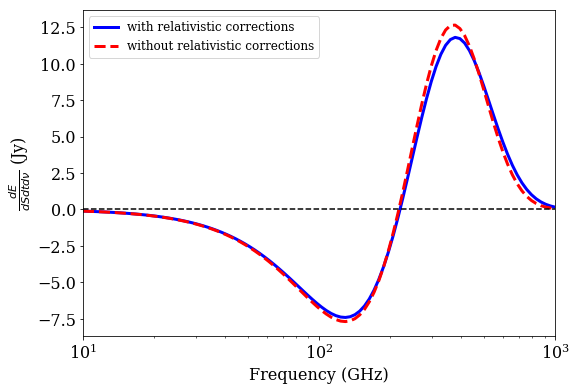

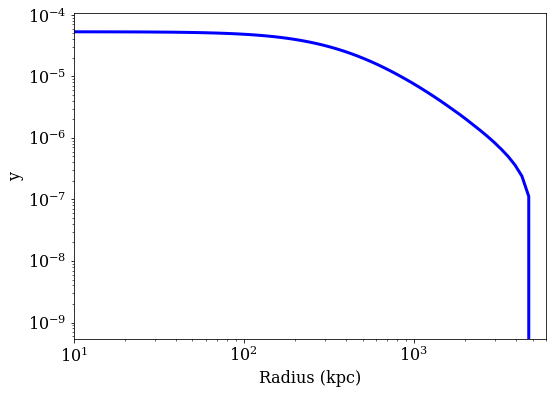

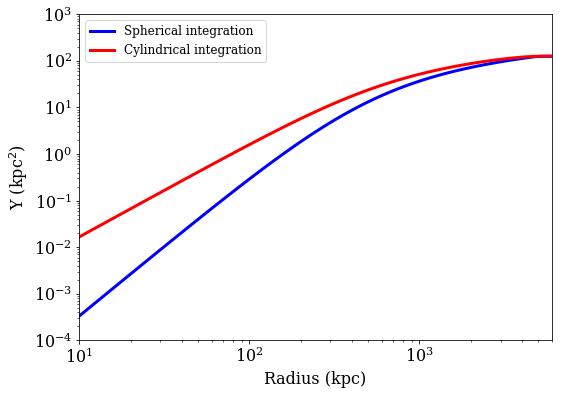

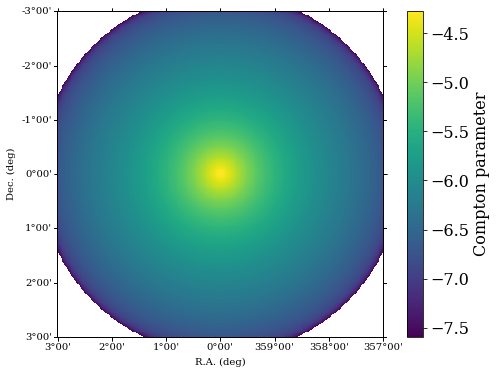

In [19]:
#---------- tSZ
f = np.logspace(1,3,100)*u.GHz
r = np.logspace(0,4,100)*u.kpc

#----- Spectrum
ctmp = copy.deepcopy(cluster)
tSZ1 = ctmp.get_sz_spectrum(frequency=f, Compton_only=False)[1]
ctmp.density_gas_model = {'name':'beta', 'n_0':1e10*u.cm**-3, 'beta':0.6, 'r_c':100*u.kpc}
tSZ2 = ctmp.get_sz_spectrum(frequency=f, Compton_only=False)[1]

plt.figure(0, figsize=(8,6))
plt.plot(f, tSZ1.to_value('Jy'), linewidth=3, label='with relativistic corrections', color='blue')
plt.plot(f, tSZ2.to_value('Jy'), linewidth=3, linestyle='--',label='without relativistic corrections', color='red')
plt.plot(f, f*0, linestyle='--', color='k')
plt.xscale('log')
plt.xlim(10,1000)
plt.xlabel('Frequency (GHz)')
plt.ylabel(r'$\frac{dE}{dSdtd\nu}$ (Jy)')
plt.legend()
plt.savefig(figdir+'/tSZ_spectra.pdf')

#----- Profile
ctmp = copy.deepcopy(cluster)
tSZ = ctmp.get_sz_profile(r, Compton_only=True)[1]
plt.figure(1, figsize=(8,6))
plt.loglog(r, tSZ.to_value('adu'), linewidth=3, color='blue')
plt.ylim(np.amax(tSZ.to_value('adu'))/1e5, np.amax(tSZ.to_value('adu'))*2)
plt.xlabel('Radius (kpc)')
plt.ylabel('y')
plt.xlim(10, 6000)
plt.savefig(figdir+'/tSZ_profile.pdf')

#----- Flux
ctmp = copy.deepcopy(cluster)
tSZ1 = ctmp.get_sz_flux(Rmax=r, type_integral='spherical', Compton_only=True, Rmin=0.1*u.kpc)
tSZ2 = ctmp.get_sz_flux(Rmax=r, type_integral='cylindrical', Compton_only=True, Rmin=0.1*u.kpc)

plt.figure(2, figsize=(8,6))
plt.loglog(r, tSZ1.to_value('kpc2'), linewidth=3, label='Spherical integration', color='blue')
plt.loglog(r, tSZ2.to_value('kpc2'), linewidth=3, label='Cylindrical integration', color='red')
plt.xlabel('Radius (kpc)')
plt.ylabel('Y (kpc$^2$)')
plt.xlim(10, 6000)
plt.ylim(1e-4, 1e3)
plt.legend()
plt.savefig(figdir+'/tSZ_flux.pdf')

print('Flux:')
print('R500, sph', ctmp.get_sz_flux(Rmax=ctmp.R500, type_integral='spherical', Compton_only=True, Rmin=0.1*u.kpc))
print('R500, cyl', ctmp.get_sz_flux(Rmax=ctmp.R500, type_integral='cylindrical', Compton_only=True, Rmin=0.1*u.kpc))
print('Rtrunc, sph', ctmp.get_sz_flux(Rmax=ctmp.R_truncation, type_integral='spherical', Compton_only=True, Rmin=0.1*u.kpc))
print('Rtrunc, cyl', ctmp.get_sz_flux(Rmax=ctmp.R_truncation, type_integral='cylindrical', Compton_only=True, Rmin=0.1*u.kpc))

#----- Map
ctmp = copy.deepcopy(cluster)
tSZ = ctmp.get_sz_map(Compton_only=True)

plt.figure(3, figsize=(8,6))
ax = plt.subplot(111, projection=WCS(ctmp.get_map_header()))
ax.set_xlabel('R.A. (deg)')
ax.set_ylabel('Dec. (deg)')
plt.imshow(np.log10(tSZ.to_value('adu')), cmap='viridis')
cb = plt.colorbar()
cb.set_label('Compton parameter')
plt.savefig(figdir+'/tSZ_map.pdf')

Flux:
('R500, sph', <Quantity 8.95181457e-11 1 / (cm2 s)>)
('R500, cyl', <Quantity 9.32881868e-11 1 / (cm2 s)>)
('Rtrunc, sph', <Quantity 1.00671834e-10 1 / (cm2 s)>)
('Rtrunc, cyl', <Quantity 1.00397044e-10 1 / (cm2 s)>)


/Users/adam/Project/anaconda3/envs/fermi/lib/python2.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log10


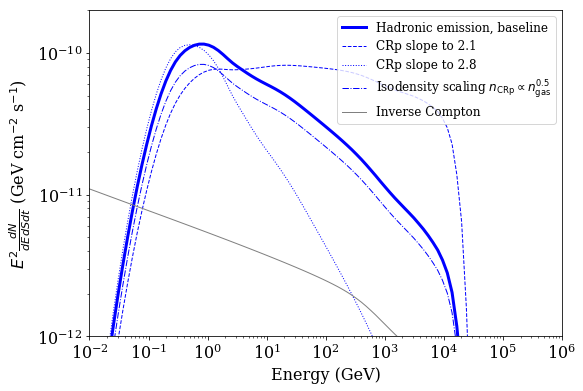

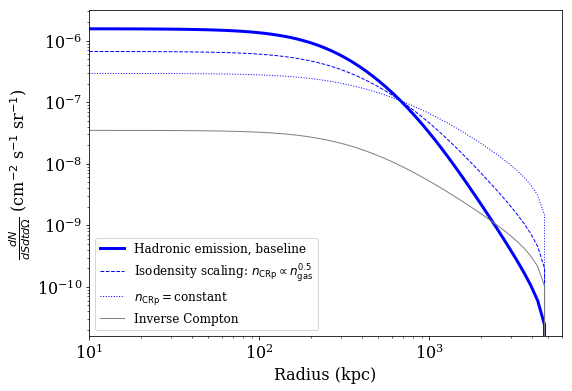

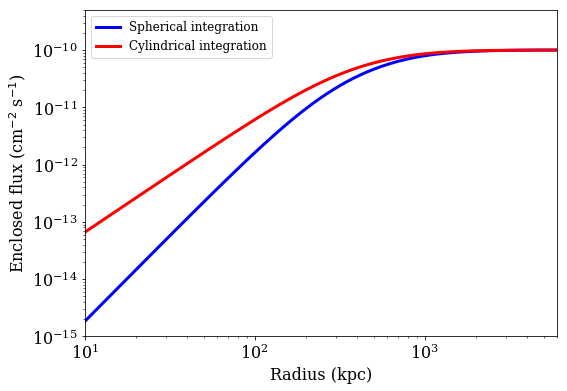

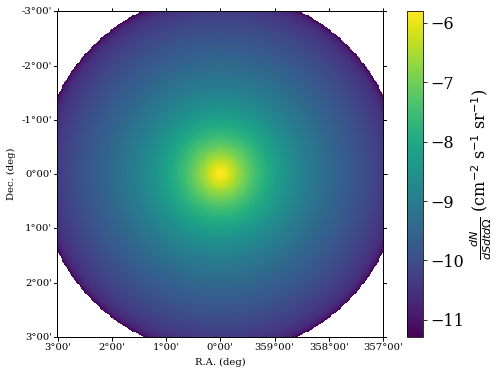

In [24]:
#---------- gamma
E = np.logspace(-2,6,100)*u.GeV
r = np.logspace(0,4,100)*u.kpc

#----- Spectrum
ctmp = copy.deepcopy(cluster)
g = ctmp.get_gamma_spectrum(E)[1]
ic = ctmp.get_ic_spectrum(E)[1]

plt.figure(0, figsize=(8,6))
plt.loglog(E, (E**2*g).to_value('GeV cm-2 s-1'), linewidth=3, label='Hadronic emission, baseline', color='blue')
ctmp2 = copy.deepcopy(cluster)
ctmp2.spectrum_crp_model['Index'] = 2.1
g = ctmp2.get_gamma_spectrum(E)[1]
plt.loglog(E, (E**2*g).to_value('GeV cm-2 s-1'), linewidth=1, linestyle='--', label='CRp slope to 2.1', color='blue')
ctmp2 = copy.deepcopy(cluster)
ctmp2.spectrum_crp_model['Index'] = 2.8
g = ctmp2.get_gamma_spectrum(E)[1]
plt.loglog(E, (E**2*g).to_value('GeV cm-2 s-1'), linewidth=1, linestyle=':', label='CRp slope to 2.8', color='blue')
ctmp2 = copy.deepcopy(cluster)
ctmp2.set_density_crp_isodens_scal_param(scal=0.5)
g = ctmp2.get_gamma_spectrum(E)[1]
plt.loglog(E, (E**2*g).to_value('GeV cm-2 s-1'), linewidth=1, linestyle='-.', label=r'Isodensity scaling $n_{\rm CRp} \propto n_{\rm gas}^{0.5}$', color='blue')
plt.loglog(E, (E**2*ic).to_value('GeV cm-2 s-1'), linewidth=1, color='grey', label='Inverse Compton')
plt.xlabel('Energy (GeV)')
plt.ylabel(r'$E^2 \frac{dN}{dEdSdt}$ (GeV cm$^{-2}$ s$^{-1}$)')
plt.xlim(1e-2, 1e6)
plt.ylim(1e-12, 2e-10)
plt.legend()
plt.savefig(figdir+'/gamma_spectra.pdf')

#----- Profile
ctmp = copy.deepcopy(cluster)
g = ctmp.get_gamma_profile(r, Emin=1*u.GeV, Emax=1*u.TeV, Energy_density=False)[1]
ic = ctmp.get_ic_profile(r, Emin=1*u.GeV, Emax=1*u.TeV, Energy_density=False)[1]

plt.figure(1, figsize=(8,6))
plt.loglog(r, g.to_value('cm-2 s-1 sr-1'), linewidth=3, label='Hadronic emission, baseline', color='blue')
plt.ylim(np.amax(g.to_value('cm-2 s-1 sr-1'))/1e5, np.amax(g.to_value('cm-2 s-1 sr-1'))*2)
ctmp2 = copy.deepcopy(cluster)
ctmp2.set_density_crp_isodens_scal_param(scal=0.5)
g = ctmp2.get_gamma_profile(r, Emin=1*u.GeV, Emax=1*u.TeV, Energy_density=False)[1]
plt.loglog(r, g.to_value('cm-2 s-1 sr-1'), linewidth=1, linestyle='--', label=r'Isodensity scaling: $n_{\rm CRp} \propto n_{\rm gas}^{0.5}$', color='blue')
ctmp2 = copy.deepcopy(cluster)
ctmp2.set_density_crp_isodens_scal_param(scal=0)
g = ctmp2.get_gamma_profile(r, Emin=1*u.GeV, Emax=1*u.TeV, Energy_density=False)[1]
plt.loglog(r, g.to_value('cm-2 s-1 sr-1'), linewidth=1, linestyle=':', label=r'$n_{\rm CRp}=$constant', color='blue')
plt.loglog(r, ic.to_value('cm-2 s-1 sr-1'), linewidth=1, color='grey', label='Inverse Compton')
plt.xlabel('Radius (kpc)')
plt.ylabel(r'$\frac{dN}{dSdtd\Omega}$ (cm$^{-2}$ s$^{-1}$ sr$^{-1}$)')
plt.xlim(10, 6000)
plt.legend()
plt.savefig(figdir+'/gamma_profile.pdf')

#----- Flux
ctmp = copy.deepcopy(cluster)
g1 = ctmp.get_gamma_flux(Rmax=r, type_integral='spherical', Rmin=0.1*u.kpc, Emin=1*u.GeV, Emax=1*u.TeV)
g2 = ctmp.get_gamma_flux(Rmax=r, type_integral='cylindrical', Rmin=0.1*u.kpc, Emin=1*u.GeV, Emax=1*u.TeV)

plt.figure(2, figsize=(8,6))
plt.loglog(r, g1.to_value('cm-2 s-1'), linewidth=3, label='Spherical integration', color='blue')
plt.loglog(r, g2.to_value('cm-2 s-1'), linewidth=3, label='Cylindrical integration', color='red')
plt.xlabel('Radius (kpc)')
plt.ylabel(r'Enclosed flux (cm$^{-2}$ s$^{-1}$)')
plt.xlim(10, 6000)
plt.ylim(1e-15, 5e-10)
plt.legend()
plt.savefig(figdir+'/gamma_flux.pdf')

print('Flux:')
print('R500, sph', ctmp.get_gamma_flux(Rmax=ctmp.R500, type_integral='spherical', Rmin=0.1*u.kpc, Emin=1*u.GeV, Emax=100*u.TeV))
print('R500, cyl', ctmp.get_gamma_flux(Rmax=ctmp.R500, type_integral='cylindrical', Rmin=0.1*u.kpc, Emin=1*u.GeV, Emax=100*u.TeV))
print('Rtrunc, sph', ctmp.get_gamma_flux(Rmax=ctmp.R_truncation, type_integral='spherical', Rmin=0.1*u.kpc, Emin=1*u.GeV, Emax=100*u.TeV))
print('Rtrunc, cyl', ctmp.get_gamma_flux(Rmax=ctmp.R_truncation, type_integral='cylindrical', Rmin=0.1*u.kpc, Emin=1*u.GeV, Emax=100*u.TeV))

#----- Map
ctmp = copy.deepcopy(cluster)
g = ctmp.get_gamma_map(Emin=1*u.GeV, Emax=1*u.TeV)

plt.figure(3, figsize=(8,6))
ax = plt.subplot(111, projection=WCS(ctmp.get_map_header()))
ax.set_xlabel('R.A. (deg)')
ax.set_ylabel('Dec. (deg)')
plt.imshow(np.log10(g.to_value('cm-2 s-1 sr-1')), cmap='viridis')
cb = plt.colorbar()
cb.set_label(r'$\frac{dN}{dSdtd\Omega}$ (cm$^{-2}$ s$^{-1}$ sr$^{-1}$)')
plt.savefig(figdir+'/gamma_map.pdf')

Flux:
('R500, sph', <Quantity 7.99632901e-11 1 / (cm2 s)>)
('R500, cyl', <Quantity 8.33309301e-11 1 / (cm2 s)>)
('Rtrunc, sph', <Quantity 8.99264725e-11 1 / (cm2 s)>)
('Rtrunc, cyl', <Quantity 8.96810122e-11 1 / (cm2 s)>)


/Users/adam/Project/anaconda3/envs/fermi/lib/python2.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in log10


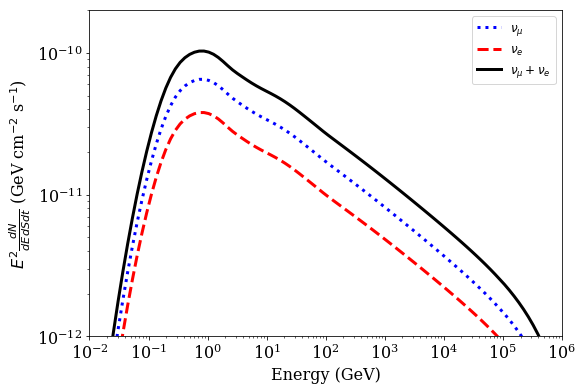

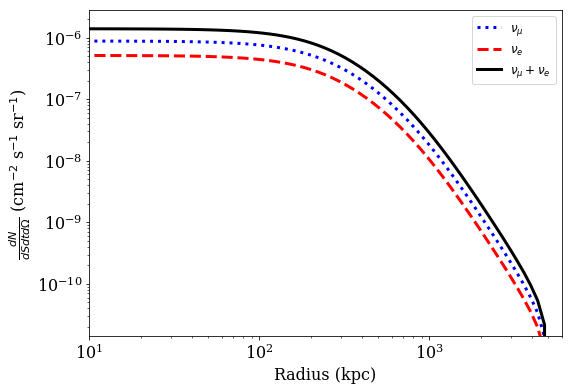

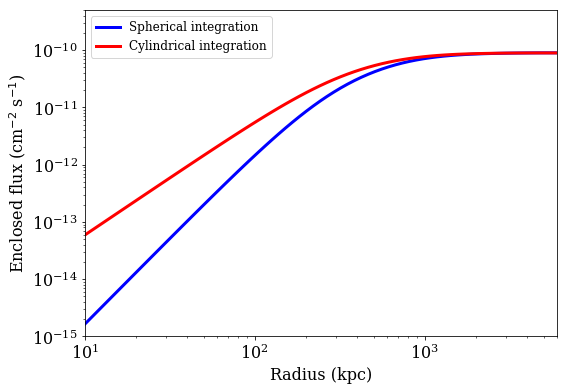

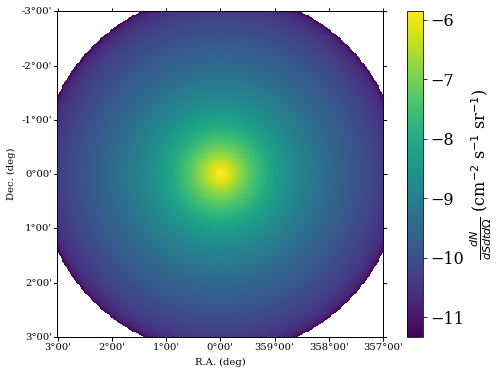

In [21]:
#---------- neutrinos
E = np.logspace(-2,6,100)*u.GeV
r = np.logspace(0,4,100)*u.kpc

#----- Spectrum
ctmp = copy.deepcopy(cluster)
n1 = ctmp.get_neutrino_spectrum(E, flavor='numu')[1]
n2 = ctmp.get_neutrino_spectrum(E, flavor='nue')[1]

plt.figure(0, figsize=(8,6))
plt.loglog(E, (E**2*n1).to_value('GeV cm-2 s-1'), linestyle=':',linewidth=3, label='$\\nu_{\\mu}$', color='blue')
plt.loglog(E, (E**2*n2).to_value('GeV cm-2 s-1'), linestyle='--',linewidth=3, label='$\\nu_{e}$', color='red')
plt.loglog(E, (E**2*(n1+n2)).to_value('GeV cm-2 s-1'), linewidth=3, label='$\\nu_{\\mu}+\\nu_{e}$', color='k')
plt.xlabel('Energy (GeV)')
plt.ylabel(r'$E^2 \frac{dN}{dEdSdt}$ (GeV cm$^{-2}$ s$^{-1}$)')
plt.xlim(1e-2, 1e6)
plt.ylim(1e-12, 2e-10)
plt.legend()
plt.savefig(figdir+'/nu_spectra.pdf')

#----- Profile
ctmp = copy.deepcopy(cluster)
n1 = ctmp.get_neutrino_profile(r, Emin=1*u.GeV, Emax=1*u.TeV, Energy_density=False, flavor='numu')[1]
n2 = ctmp.get_neutrino_profile(r, Emin=1*u.GeV, Emax=1*u.TeV, Energy_density=False, flavor='nue')[1]

plt.figure(1, figsize=(8,6))
plt.loglog(r, n1.to_value('cm-2 s-1 sr-1'), linestyle=':', linewidth=3, label='$\\nu_{\\mu}$', color='blue')
plt.loglog(r, n2.to_value('cm-2 s-1 sr-1'), linestyle='--', linewidth=3, label='$\\nu_{e}$', color='red')
plt.loglog(r, (n1+n2).to_value('cm-2 s-1 sr-1'), linewidth=3, label='$\\nu_{\\mu}+\\nu_{e}$', color='k')
plt.ylim(np.amax((n1+n2).to_value('cm-2 s-1 sr-1'))/1e5, np.amax((n1+n2).to_value('cm-2 s-1 sr-1'))*2)
plt.xlim(10, 6000)
plt.xlabel('Radius (kpc)')
plt.ylabel(r'$\frac{dN}{dSdtd\Omega}$ (cm$^{-2}$ s$^{-1}$ sr$^{-1}$)')
plt.legend()
plt.savefig(figdir+'/nu_profile.pdf')

#----- Flux
ctmp = copy.deepcopy(cluster)
n1 = ctmp.get_neutrino_flux(Rmax=r, type_integral='spherical', Rmin=0.1*u.kpc, Emin=1*u.GeV, Emax=1*u.TeV, flavor='all')
n2 = ctmp.get_neutrino_flux(Rmax=r, type_integral='cylindrical', Rmin=0.1*u.kpc, Emin=1*u.GeV, Emax=1*u.TeV, flavor='all')

plt.figure(2, figsize=(8,6))
plt.loglog(r, n1.to_value('cm-2 s-1'), linewidth=3, label='Spherical integration', color='blue')
plt.loglog(r, n2.to_value('cm-2 s-1'), linewidth=3, label='Cylindrical integration', color='red')
plt.xlabel('Radius (kpc)')
plt.ylabel(r'Enclosed flux (cm$^{-2}$ s$^{-1}$)')
plt.xlim(10, 6000)
plt.ylim(1e-15, 5e-10)
plt.legend()
plt.savefig(figdir+'/nu_flux.pdf')

print('Flux:')
print('R500, sph', ctmp.get_neutrino_flux(Rmax=ctmp.R500, flavor='all',type_integral='spherical', Rmin=0.1*u.kpc, Emin=1*u.GeV, Emax=100*u.TeV))
print('R500, cyl', ctmp.get_neutrino_flux(Rmax=ctmp.R500, flavor='all',type_integral='cylindrical', Rmin=0.1*u.kpc, Emin=1*u.GeV, Emax=100*u.TeV))
print('Rtrunc, sph', ctmp.get_neutrino_flux(Rmax=ctmp.R_truncation, flavor='all',type_integral='spherical', Rmin=0.1*u.kpc, Emin=1*u.GeV, Emax=100*u.TeV))
print('Rtrunc, cyl', ctmp.get_neutrino_flux(Rmax=ctmp.R_truncation, flavor='all',type_integral='cylindrical', Rmin=0.1*u.kpc, Emin=1*u.GeV, Emax=100*u.TeV))

#----- Map
ctmp = copy.deepcopy(cluster)
n = ctmp.get_neutrino_map(Emin=1*u.GeV, Emax=1*u.TeV, flavor='all')

plt.figure(3, figsize=(8,6))
ax = plt.subplot(111, projection=WCS(ctmp.get_map_header()))
ax.set_xlabel('R.A. (deg)')
ax.set_ylabel('Dec. (deg)')
plt.imshow(np.log10(n.to_value('cm-2 s-1 sr-1')), cmap='viridis')
cb = plt.colorbar()
cb.set_label(r'$\frac{dN}{dSdtd\Omega}$ (cm$^{-2}$ s$^{-1}$ sr$^{-1}$)')
plt.savefig(figdir+'/nu_map.pdf')

Flux:
('R500, sph', <Quantity 4.65753179e-12 1 / (cm2 s)>)
('R500, cyl', <Quantity 6.17224796e-12 1 / (cm2 s)>)
('Rtrunc, sph', <Quantity 1.22939064e-11 1 / (cm2 s)>)
('Rtrunc, cyl', <Quantity 1.22491375e-11 1 / (cm2 s)>)


/Users/adam/Project/anaconda3/envs/fermi/lib/python2.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: divide by zero encountered in log10


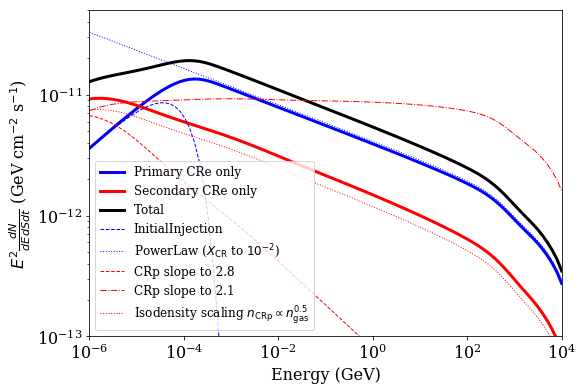

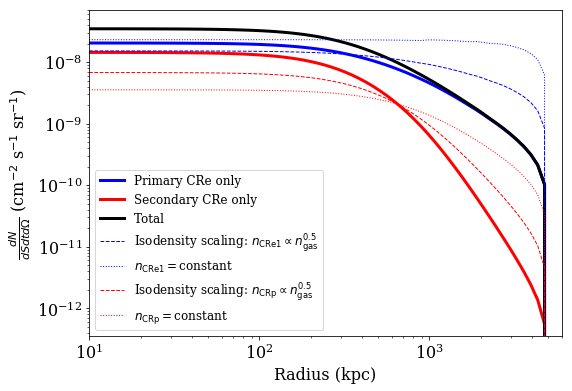

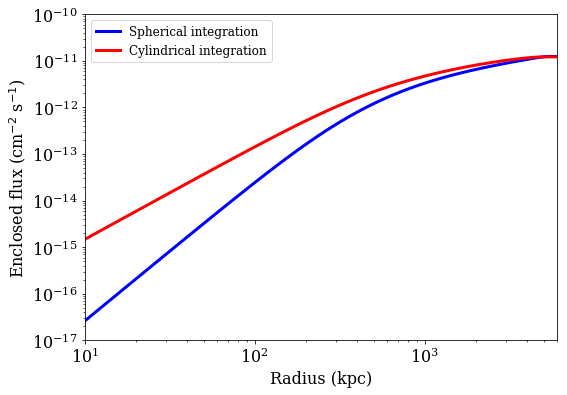

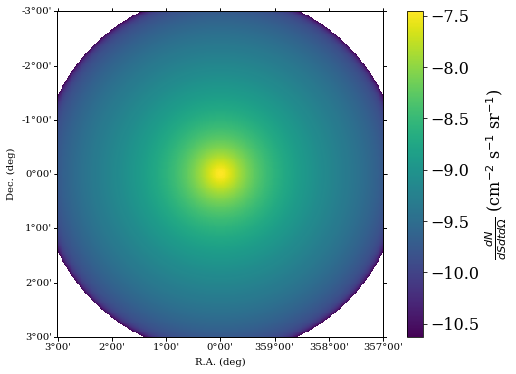

In [22]:
#---------- IC
E = np.logspace(-6,4,100)*u.GeV
r = np.logspace(0,4,100)*u.kpc

#----- Spectrum
ctmp = copy.deepcopy(cluster)
ctmp.X_crp_E  = {'X':0.00, 'R_norm':ctmp.R500}
g1 = ctmp.get_ic_spectrum(E)[1]
ctmp = copy.deepcopy(cluster)
ctmp.X_cre1_E = {'X':0.00, 'R_norm':ctmp.R500}
g2 = ctmp.get_ic_spectrum(E)[1]
plt.figure(0, figsize=(8,6))
plt.loglog(E, (E**2*g1).to_value('GeV cm-2 s-1'), linewidth=3, label='Primary CRe only', color='blue')
plt.loglog(E, (E**2*g2).to_value('GeV cm-2 s-1'), linewidth=3, label='Secondary CRe only',color='red')
plt.loglog(E, (E**2*(g1+g2)).to_value('GeV cm-2 s-1'), linewidth=3, linestyle='-', label='Total',color='k')
ctmp = copy.deepcopy(cluster)
ctmp.X_crp_E = {'X':0.00, 'R_norm':ctmp.R500}
ctmp.spectrum_cre1_model['name'] = 'InitialInjection'
g = ctmp.get_ic_spectrum(E)[1]
plt.loglog(E, (E**2*g).to_value('GeV cm-2 s-1'), linewidth=1, label='InitialInjection', linestyle='--',color='blue')
ctmp = copy.deepcopy(cluster)
ctmp.X_crp_E = {'X':0.00, 'R_norm':ctmp.R500}
ctmp.spectrum_cre1_model = {'name':'PowerLaw', 'Index':cluster.spectrum_cre1_model['Index']+1}
ctmp.X_cre1_E = {'X':1e-2, 'R_norm':ctmp.R500}
g = ctmp.get_ic_spectrum(E)[1]
plt.loglog(E, (E**2*g).to_value('GeV cm-2 s-1'), linewidth=1, label='PowerLaw ($X_{\mathrm{CR}}$ to $10^{-2}$)', linestyle=':',color='blue')
ctmp = copy.deepcopy(cluster)
ctmp.X_crp_E = {'X':0.01, 'R_norm':ctmp.R500}
ctmp.spectrum_crp_model = {'name':'PowerLaw', 'Index':2.8}
ctmp.X_cre1_E = {'X':0, 'R_norm':ctmp.R500}
g = ctmp.get_ic_spectrum(E)[1]
plt.loglog(E, (E**2*g).to_value('GeV cm-2 s-1'), linewidth=1, label='CRp slope to 2.8', linestyle='--',color='red')
ctmp = copy.deepcopy(cluster)
ctmp.X_crp_E = {'X':0.01, 'R_norm':ctmp.R500}
ctmp.spectrum_crp_model = {'name':'PowerLaw', 'Index':2.1}
ctmp.X_cre1_E = {'X':0, 'R_norm':ctmp.R500}
g = ctmp.get_ic_spectrum(E)[1]
plt.loglog(E, (E**2*g).to_value('GeV cm-2 s-1'), linewidth=1, label='CRp slope to 2.1', linestyle='-.',color='red')
ctmp = copy.deepcopy(cluster)
ctmp.X_crp_E = {'X':0.01, 'R_norm':ctmp.R500}
ctmp.spectrum_crp_model = {'name':'PowerLaw', 'Index':2.4}
ctmp.X_cre1_E = {'X':0, 'R_norm':ctmp.R500}
ctmp.set_density_crp_isodens_scal_param(scal=0.5)
g = ctmp.get_ic_spectrum(E)[1]
plt.loglog(E, (E**2*g).to_value('GeV cm-2 s-1'), linewidth=1, label=r'Isodensity scaling $n_{\rm CRp} \propto n_{\rm gas}^{0.5}$', linestyle=':',color='red')

plt.xlabel('Energy (GeV)')
plt.ylabel(r'$E^2 \frac{dN}{dEdSdt}$ (GeV cm$^{-2}$ s$^{-1}$)')
plt.ylim(1e-13, 5e-11)
plt.xlim(1e-6, 1e4)
plt.legend()
plt.savefig(figdir+'/ic_spectra.pdf')

#----- Profile
ctmp = copy.deepcopy(cluster)
ctmp.X_crp_E  = {'X':0.00, 'R_norm':ctmp.R500}
g1 = ctmp.get_ic_profile(r, Emin=1*u.GeV, Emax=1*u.TeV, Energy_density=False)[1]
ctmp = copy.deepcopy(cluster)
ctmp.X_cre1_E = {'X':0.00, 'R_norm':ctmp.R500}
g2 = ctmp.get_ic_profile(r, Emin=1*u.GeV, Emax=1*u.TeV, Energy_density=False)[1]

plt.figure(1, figsize=(8,6))
plt.loglog(r, g1.to_value('cm-2 s-1 sr-1'), linewidth=3, label='Primary CRe only', color='blue')
plt.loglog(r, g2.to_value('cm-2 s-1 sr-1'), linewidth=3, label='Secondary CRe only', color='red')
plt.loglog(r, (g1+g2).to_value('cm-2 s-1 sr-1'), linewidth=3, label='Total', linestyle='-', color='k')

ctmp = copy.deepcopy(cluster)
ctmp.X_crp_E = {'X':0.00, 'R_norm':ctmp.R500}
ctmp.set_density_cre1_isodens_scal_param(scal=0.5)
g = ctmp.get_ic_profile(r, Emin=1*u.GeV, Emax=1*u.TeV, Energy_density=False)[1]
plt.loglog(r, g.to_value('cm-2 s-1 sr-1'), linewidth=1, linestyle='--', label=r'Isodensity scaling: $n_{\rm CRe1} \propto n_{\rm gas}^{0.5}$', color='blue')
ctmp = copy.deepcopy(cluster)
ctmp.X_crp_E = {'X':0.00, 'R_norm':ctmp.R500}
ctmp.set_density_cre1_isodens_scal_param(scal=0)
g = ctmp.get_ic_profile(r, Emin=1*u.GeV, Emax=1*u.TeV, Energy_density=False)[1]
plt.loglog(r, g.to_value('cm-2 s-1 sr-1'), linewidth=1, linestyle=':', label=r'$n_{\rm CRe1} = $constant', color='blue')

ctmp = copy.deepcopy(cluster)
ctmp.X_cre1_E = {'X':0.00, 'R_norm':ctmp.R500}
ctmp.set_density_crp_isodens_scal_param(scal=0.5)
g = ctmp.get_ic_profile(r, Emin=1*u.GeV, Emax=1*u.TeV, Energy_density=False)[1]
plt.loglog(r, g.to_value('cm-2 s-1 sr-1'), linewidth=1, linestyle='--', label=r'Isodensity scaling: $n_{\rm CRp} \propto n_{\rm gas}^{0.5}$', color='red')
ctmp = copy.deepcopy(cluster)
ctmp.X_cre1_E = {'X':0.00, 'R_norm':ctmp.R500}
ctmp.set_density_crp_isodens_scal_param(scal=0)
g = ctmp.get_ic_profile(r, Emin=1*u.GeV, Emax=1*u.TeV, Energy_density=False)[1]
plt.loglog(r, g.to_value('cm-2 s-1 sr-1'), linewidth=1, linestyle=':', label=r'$n_{\rm CRp} = $constant', color='red')

plt.ylim(np.amax((g1+g2).to_value('cm-2 s-1 sr-1'))/1e5, np.amax((g1+g2).to_value('cm-2 s-1 sr-1'))*2)
plt.xlabel('Radius (kpc)')
plt.ylabel(r'$\frac{dN}{dSdtd\Omega}$ (cm$^{-2}$ s$^{-1}$ sr$^{-1}$)')
plt.xlim(10, 6000)
plt.legend()
plt.savefig(figdir+'/ic_profile.pdf')

#----- Flux
ctmp = copy.deepcopy(cluster)
g1 = ctmp.get_ic_flux(Rmax=r, type_integral='spherical', Rmin=0.1*u.kpc, Emin=1*u.GeV, Emax=1*u.TeV)
g2 = ctmp.get_ic_flux(Rmax=r, type_integral='cylindrical', Rmin=0.1*u.kpc, Emin=1*u.GeV, Emax=1*u.TeV)

plt.figure(2, figsize=(8,6))
plt.loglog(r, g1.to_value('cm-2 s-1'), linewidth=3, label='Spherical integration', color='blue')
plt.loglog(r, g2.to_value('cm-2 s-1'), linewidth=3, label='Cylindrical integration', color='red')
plt.xlabel('Radius (kpc)')
plt.ylabel(r'Enclosed flux (cm$^{-2}$ s$^{-1}$)')
plt.xlim(10, 6000)
plt.ylim(1e-17, 1e-10)
plt.legend()
plt.savefig(figdir+'/ic_flux.pdf')

print('Flux:')
print('R500, sph', ctmp.get_ic_flux(Rmax=ctmp.R500, type_integral='spherical', Rmin=0.1*u.kpc, Emin=1*u.GeV, Emax=100*u.TeV))
print('R500, cyl', ctmp.get_ic_flux(Rmax=ctmp.R500, type_integral='cylindrical', Rmin=0.1*u.kpc, Emin=1*u.GeV, Emax=100*u.TeV))
print('Rtrunc, sph', ctmp.get_ic_flux(Rmax=ctmp.R_truncation, type_integral='spherical', Rmin=0.1*u.kpc, Emin=1*u.GeV, Emax=100*u.TeV))
print('Rtrunc, cyl', ctmp.get_ic_flux(Rmax=ctmp.R_truncation, type_integral='cylindrical', Rmin=0.1*u.kpc, Emin=1*u.GeV, Emax=100*u.TeV))

#----- Map
ctmp = copy.deepcopy(cluster)
g = ctmp.get_ic_map(Emin=1*u.GeV, Emax=1*u.TeV)

plt.figure(3, figsize=(8,6))
ax = plt.subplot(111, projection=WCS(ctmp.get_map_header()))
ax.set_xlabel('R.A. (deg)')
ax.set_ylabel('Dec. (deg)')
plt.imshow(np.log10(g.to_value('cm-2 s-1 sr-1')), cmap='viridis')
cb = plt.colorbar()
cb.set_label(r'$\frac{dN}{dSdtd\Omega}$ (cm$^{-2}$ s$^{-1}$ sr$^{-1}$)')
plt.savefig(figdir+'/ic_map.pdf')

Flux:
('R500, sph', <Quantity [1.42428052] Jy>)
('R500, cyl', <Quantity [1.45856822] Jy>)
('Rtrunc, sph', <Quantity [1.52675659] Jy>)
('Rtrunc, cyl', <Quantity [1.52201194] Jy>)


/Users/adam/Project/anaconda3/envs/fermi/lib/python2.7/site-packages/ipykernel_launcher.py:123: RuntimeWarning: divide by zero encountered in log10


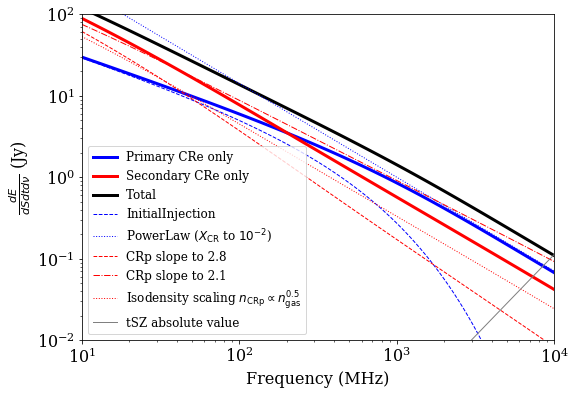

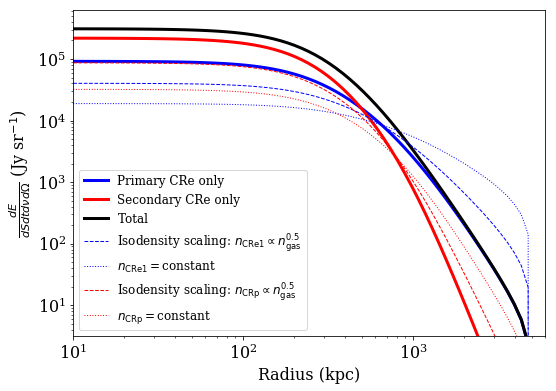

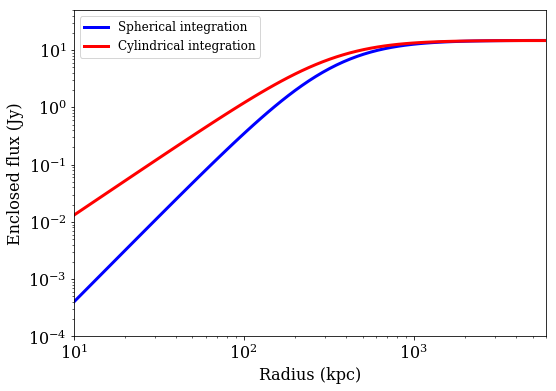

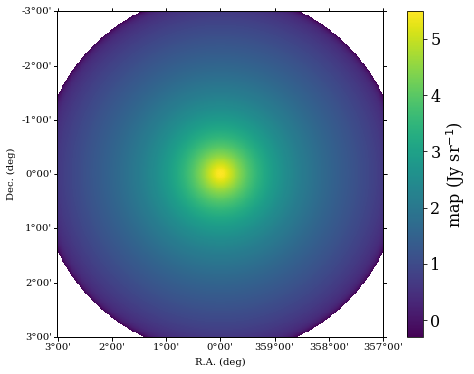

In [23]:
#---------- Synchrotron
f = np.logspace(1,4,100)*u.MHz
r = np.logspace(0,4,100)*u.kpc

#----- Spectrum
ctmp = copy.deepcopy(cluster)
ctmp.X_crp_E  = {'X':0.00, 'R_norm':ctmp.R500}
g1 = ctmp.get_synchrotron_spectrum(f)[1]
ctmp = copy.deepcopy(cluster)
ctmp.X_cre1_E = {'X':0.00, 'R_norm':ctmp.R500}
g2 = ctmp.get_synchrotron_spectrum(f)[1]
sz = ctmp.get_sz_spectrum(f, Compton_only=False)[1]
plt.figure(0, figsize=(8,6))
plt.loglog(f, g1.to_value('Jy'), linewidth=3, label='Primary CRe only', color='blue')
plt.loglog(f, g2.to_value('Jy'), linewidth=3, label='Secondary CRe only', color='red')
plt.loglog(f, (g1+g2).to_value('Jy'), linewidth=3, label='Total', color='k')
ctmp = copy.deepcopy(cluster)
ctmp.X_crp_E = {'X':0.00, 'R_norm':ctmp.R500}
ctmp.spectrum_cre1_model['name'] = 'InitialInjection'
g = ctmp.get_synchrotron_spectrum(f)[1]
plt.loglog(f, g.to_value('Jy'), linewidth=1, label='InitialInjection', linestyle='--',color='blue')
ctmp = copy.deepcopy(cluster)
ctmp.X_crp_E = {'X':0.00, 'R_norm':ctmp.R500}
ctmp.spectrum_cre1_model = {'name':'PowerLaw', 'Index':cluster.spectrum_cre1_model['Index']+1}
ctmp.X_cre1_E = {'X':1e-2, 'R_norm':ctmp.R500}
g = ctmp.get_synchrotron_spectrum(f)[1]
plt.loglog(f, g.to_value('Jy'), linewidth=1, label='PowerLaw ($X_{\mathrm{CR}}$ to $10^{-2}$)', linestyle=':',color='blue')
ctmp = copy.deepcopy(cluster)
ctmp.X_crp_E = {'X':0.01, 'R_norm':ctmp.R500}
ctmp.spectrum_crp_model = {'name':'PowerLaw', 'Index':2.8}
ctmp.X_cre1_E = {'X':0, 'R_norm':ctmp.R500}
g = ctmp.get_synchrotron_spectrum(f)[1]
plt.loglog(f, g.to_value('Jy'), linewidth=1, label='CRp slope to 2.8', linestyle='--',color='red')
ctmp = copy.deepcopy(cluster)
ctmp.X_crp_E = {'X':0.01, 'R_norm':ctmp.R500}
ctmp.spectrum_crp_model = {'name':'PowerLaw', 'Index':2.1}
ctmp.X_cre1_E = {'X':0, 'R_norm':ctmp.R500}
g = ctmp.get_synchrotron_spectrum(f)[1]
plt.loglog(f, g.to_value('Jy'), linewidth=1, label='CRp slope to 2.1', linestyle='-.',color='red')
ctmp = copy.deepcopy(cluster)
ctmp.X_crp_E = {'X':0.01, 'R_norm':ctmp.R500}
ctmp.spectrum_crp_model = {'name':'PowerLaw', 'Index':2.4}
ctmp.X_cre1_E = {'X':0, 'R_norm':ctmp.R500}
ctmp.set_density_crp_isodens_scal_param(scal=0.5)
g = ctmp.get_synchrotron_spectrum(f)[1]
plt.loglog(f, g.to_value('Jy'), linewidth=1, label=r'Isodensity scaling $n_{\rm CRp} \propto n_{\rm gas}^{0.5}$', linestyle=':',color='red')
plt.loglog(f, np.abs(sz.to_value('Jy')), linewidth=1, label='tSZ absolute value', color='grey')
plt.xlabel('Frequency (MHz)')
plt.ylabel(r'$\frac{dE}{dSdtd\nu}$ (Jy)')
plt.ylim(1e-2, 1e2)
plt.xlim(1e1, 1e4)
plt.legend()
plt.savefig(figdir+'/sync_spectra.pdf')

#----- Profile
ctmp = copy.deepcopy(cluster)
ctmp.X_crp_E  = {'X':0.00, 'R_norm':ctmp.R500}
g1 = ctmp.get_synchrotron_profile(r, freq0=100*u.MHz)[1]
ctmp = copy.deepcopy(cluster)
ctmp.X_cre1_E = {'X':0.00, 'R_norm':ctmp.R500}
g2 = ctmp.get_synchrotron_profile(r, freq0=100*u.MHz)[1]

plt.figure(1, figsize=(8,6))
plt.loglog(r, g1.to_value('Jy sr-1'), linewidth=3, label='Primary CRe only', color='blue')
plt.loglog(r, g2.to_value('Jy sr-1'), linewidth=3, label='Secondary CRe only', color='red')
plt.loglog(r, (g1+g2).to_value('Jy sr-1'), linewidth=3, label='Total', color='k')
plt.ylim(np.amax((g1+g2).to_value('Jy sr-1'))/1e5, np.amax((g1+g2).to_value('Jy sr-1'))*2)
ctmp = copy.deepcopy(cluster)
ctmp.X_crp_E = {'X':0.00, 'R_norm':ctmp.R500}
ctmp.set_density_cre1_isodens_scal_param(scal=0.5)
g = ctmp.get_synchrotron_profile(r, freq0=100*u.MHz)[1]
plt.loglog(r, g.to_value('Jy sr-1'), linewidth=1, linestyle='--', label=r'Isodensity scaling: $n_{\rm CRe1} \propto n_{\rm gas}^{0.5}$', color='blue')
ctmp = copy.deepcopy(cluster)
ctmp.X_crp_E = {'X':0.00, 'R_norm':ctmp.R500}
ctmp.set_density_cre1_isodens_scal_param(scal=0)
g = ctmp.get_synchrotron_profile(r, freq0=100*u.MHz)[1]
plt.loglog(r, g.to_value('Jy sr-1'), linewidth=1, linestyle=':', label=r'$n_{\rm CRe1} = $constant', color='blue')
ctmp = copy.deepcopy(cluster)
ctmp.X_cre1_E = {'X':0.00, 'R_norm':ctmp.R500}
ctmp.set_density_crp_isodens_scal_param(scal=0.5)
g = ctmp.get_synchrotron_profile(r, freq0=100*u.MHz)[1]
plt.loglog(r, g.to_value('Jy sr-1'), linewidth=1, linestyle='--', label=r'Isodensity scaling: $n_{\rm CRp} \propto n_{\rm gas}^{0.5}$', color='red')
ctmp = copy.deepcopy(cluster)
ctmp.X_cre1_E = {'X':0.00, 'R_norm':ctmp.R500}
ctmp.set_density_crp_isodens_scal_param(scal=0)
g = ctmp.get_synchrotron_profile(r, freq0=100*u.MHz)[1]
plt.loglog(r, g.to_value('Jy sr-1'), linewidth=1, linestyle=':', label=r'$n_{\rm CRp} = $constant', color='red')
plt.xlabel('Radius (kpc)')
plt.ylabel(r'$\frac{dE}{dSdtd\nu d\Omega}$ (Jy sr$^{-1}$)')
plt.xlim(10, 6000)
plt.legend()
plt.savefig(figdir+'/sync_profile.pdf')

#----- Flux
ctmp = copy.deepcopy(cluster)
g1 = ctmp.get_synchrotron_flux(Rmax=r, type_integral='spherical', Rmin=0.1*u.kpc, freq0=100*u.MHz)
g2 = ctmp.get_synchrotron_flux(Rmax=r, type_integral='cylindrical', Rmin=0.1*u.kpc, freq0=100*u.MHz)

plt.figure(2, figsize=(8,6))
plt.loglog(r, g1.to_value('Jy'), linewidth=3, label='Spherical integration', color='blue')
plt.loglog(r, g2.to_value('Jy'), linewidth=3, label='Cylindrical integration', color='red')
plt.xlabel('Radius (kpc)')
plt.ylabel(r'Enclosed flux (Jy)')
plt.xlim(10, 6000)
plt.ylim(1e-4, 5e1)
plt.legend()
plt.savefig(figdir+'/sync_flux.pdf')

print('Flux:')
print('R500, sph', ctmp.get_synchrotron_flux(Rmax=ctmp.R500, type_integral='spherical', Rmin=0.1*u.kpc, freq0=1*u.GHz))
print('R500, cyl', ctmp.get_synchrotron_flux(Rmax=ctmp.R500, type_integral='cylindrical', Rmin=0.1*u.kpc, freq0=1*u.GHz))
print('Rtrunc, sph', ctmp.get_synchrotron_flux(Rmax=ctmp.R_truncation, type_integral='spherical', Rmin=0.1*u.kpc, freq0=1*u.GHz))
print('Rtrunc, cyl', ctmp.get_synchrotron_flux(Rmax=ctmp.R_truncation, type_integral='cylindrical', Rmin=0.1*u.kpc, freq0=1*u.GHz))

#----- Map
ctmp = copy.deepcopy(cluster)
g = ctmp.get_synchrotron_map(freq0=100*u.MHz)

plt.figure(3, figsize=(8,6))
ax = plt.subplot(111, projection=WCS(ctmp.get_map_header()))
ax.set_xlabel('R.A. (deg)')
ax.set_ylabel('Dec. (deg)')
plt.imshow(np.log10(g.to_value('Jy sr-1')), cmap='viridis')
cb = plt.colorbar()
cb.set_label(r'map (Jy sr$^{-1}$)')
plt.savefig(figdir+'/sync_map.pdf')

# Prediction for Xcop clusters

### Planck and RASS comparison

In [179]:
FWHM2sigma = 1.0/(2.0*np.sqrt(2*np.log(2)))
planck_beam = 10*u.arcmin
rass_beam   = 4.5*u.arcmin
smoothing   = 3*u.arcmin

/Users/adam/Project/anaconda3/envs/fermi/lib/python2.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/Users/adam/Project/anaconda3/envs/fermi/lib/python2.7/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))
/Users/adam/Project/anaconda3/envs/fermi/lib/python2.7/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/Users/adam/Project/anaconda3/envs/fermi/lib/python2.7/site-packages/matplotlib/contour.py:967: UserWarning: Th

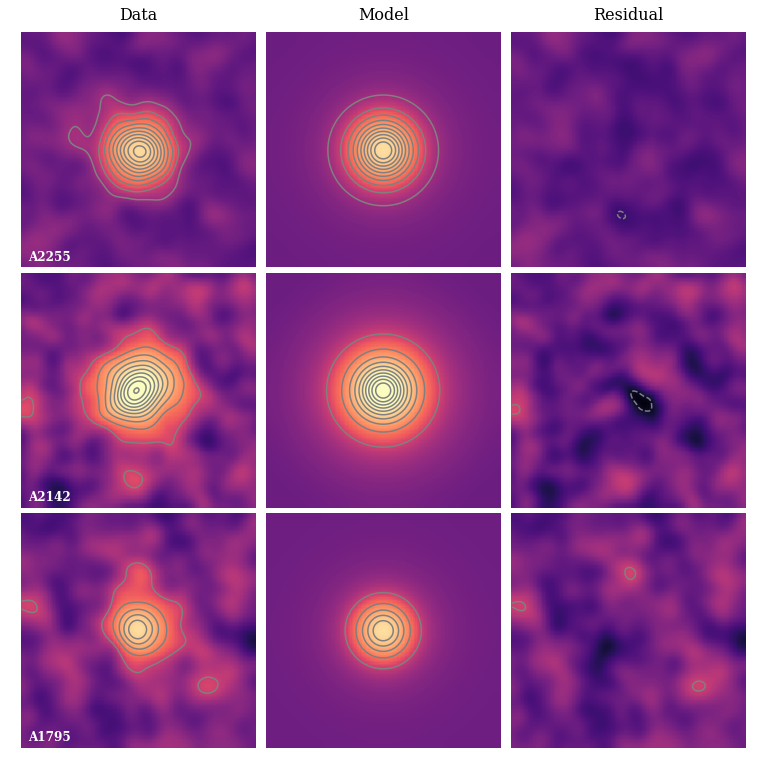

In [228]:
fig, ax = plt.subplots(3,3,figsize=(10,10), sharex=True, sharey=True)
i=0
for cl in cluster_list:
    c = copy.deepcopy(cl)
    c.map_fov = 1.5*u.deg
    c.map_reso = 0.5*u.arcmin
    ymap, header = map_tools.roi_extract_healpix(plck_file, c.coord.ra.to_value('deg'), c.coord.dec.to_value('deg'), c.map_reso.to_value('deg'), [c.map_fov[0].to_value('deg'), c.map_fov[1].to_value('deg')], visu=False)
    c.map_header = header
    ymap_model = c.get_sz_map(Compton_only=True)
    ymap_model = 1e6*gaussfilt(ymap_model.value, sigma=np.sqrt(smoothing.to_value('deg')**2+planck_beam.to_value('deg')**2)/header['CDELT2']*FWHM2sigma)
    ymap       = 1e6*gaussfilt(ymap, sigma=smoothing.to_value('deg')/header['CDELT2']*FWHM2sigma)
    rms = np.std(ymap-ymap_model)
    
    ax[i,0].imshow(ymap, origin='lower', cmap='magma',norm=SymLogNorm(7, vmin=-7, vmax=40))
    ax[i,0].contour(ymap, levels=(np.array(range(10))+1)*3*rms, colors='grey', alpha=1)
    ax[i,0].contour(ymap, levels=(-(np.array(range(10))+1))[::-1]*3*rms, colors='grey', alpha=1, linestyle='--')
    ax[i,1].imshow(ymap_model, origin='lower', cmap='magma',norm=SymLogNorm(7, vmin=-7, vmax=40))
    ax[i,1].contour(ymap_model, levels=(np.array(range(10))+1)*3*rms, colors='grey', alpha=1)
    ax[i,1].contour(ymap_model, levels=(-(np.array(range(10))+1))[::-1]*3*rms, colors='grey', alpha=1, linestyle='--')
    ax[i,2].imshow(ymap-ymap_model, origin='lower', cmap='magma',norm=SymLogNorm(7, vmin=-7, vmax=40))
    ax[i,2].contour(ymap-ymap_model, levels=(np.array(range(10))+1)*3*rms, colors='grey', alpha=1)
    ax[i,2].contour(ymap-ymap_model, levels=(-(np.array(range(10))+1))[::-1]*3*rms, colors='grey', alpha=1, linestyle='--')
    ax[i,0].text(5.0, 5.0, c.name, fontsize=12, color='white', fontweight='bold')
    ax[i,0].axis('off')
    ax[i,1].axis('off')
    ax[i,2].axis('off')
    if i==0:
        ax[i,0].set_title('Data')
        ax[i,1].set_title('Model')
        ax[i,2].set_title('Residual')
    i=i+1
fig.subplots_adjust(wspace=None, hspace=None)
plt.xticks([])
plt.yticks([])
plt.tight_layout(pad=-1)
plt.savefig(figdir+'/XCOP_ymap.pdf')

<type 'numpy.ndarray'>


/Users/adam/Project/anaconda3/envs/fermi/lib/python2.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/Users/adam/Project/anaconda3/envs/fermi/lib/python2.7/site-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/adam/Project/anaconda3/envs/fermi/lib/python2.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly s

<type 'numpy.ndarray'>


/Users/adam/Project/anaconda3/envs/fermi/lib/python2.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/Users/adam/Project/anaconda3/envs/fermi/lib/python2.7/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/Users/adam/Project/anaconda3/envs/fermi/lib/python2.7/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'linestyle'
  s)
/Users/adam/Project/anaconda3/envs/fermi/lib/python2.7/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("

<type 'numpy.ndarray'>


/Users/adam/Project/anaconda3/envs/fermi/lib/python2.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/Users/adam/Project/anaconda3/envs/fermi/lib/python2.7/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/Users/adam/Project/anaconda3/envs/fermi/lib/python2.7/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'linestyle'
  s)
/Users/adam/Project/anaconda3/envs/fermi/lib/python2.7/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("

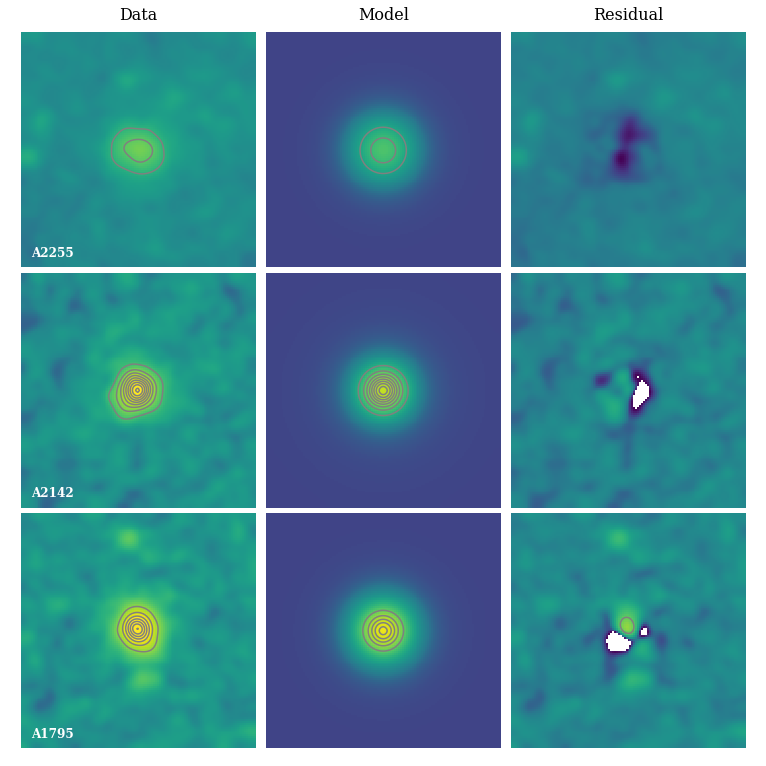

In [232]:
fig, ax = plt.subplots(3,3,figsize=(10,10), sharex=True, sharey=True)
i=0
for cl in cluster_list:
    coeff = 5.24559/(hp.nside2resol(2048, arcmin=True)**2)
    c = copy.deepcopy(cl)
    c.map_fov = 1*u.deg
    c.map_reso = 0.5*u.arcmin
    c.make_xspec_table(Emin=0.1*u.keV, Emax=2.4*u.keV,Tmin=0.1*u.keV, Tmax=30.0*u.keV, nbin=10,file_HI=lab_file, visu_nH=False, model='APEC',resp_file=pspc_resp_file, data_file=pspc_sp_file, app_nH_model=True)
    xmap, header = map_tools.roi_extract_healpix(rass_file, c.coord.ra.to_value('deg'), c.coord.dec.to_value('deg'), c.map_reso.to_value('deg'), [c.map_fov[0].to_value('deg'), c.map_fov[1].to_value('deg')], visu=False)
    c.map_header = header
    xmap_model = c.get_xray_map(output_type='R')
    xmap_model = gaussfilt(xmap_model.value, sigma=np.sqrt(smoothing.to_value('deg')**2+rass_beam.to_value('deg')**2)/header['CDELT2']*FWHM2sigma)*xmap_model.unit
    xmap       = gaussfilt(xmap, sigma=smoothing.to_value('deg')/header['CDELT2']*FWHM2sigma)
    rms = np.std(coeff*xmap-xmap_model.to_value('s-1 arcmin-2'))

    ax[i,0].imshow(coeff*xmap, origin='lower',norm=SymLogNorm(0.001, vmin=-0.001, vmax=0.05))
    ax[i,0].contour(coeff*xmap, levels=(np.array(range(100))+1)*10*rms, colors='grey', alpha=1)
    ax[i,0].contour(coeff*xmap, levels=(-(np.array(range(100))+1))[::-1]*10*rms, colors='grey', alpha=1, linestyle='--')
    ax[i,1].imshow(xmap_model.to_value('s-1 arcmin-2'), origin='lower',norm=SymLogNorm(0.001, vmin=-0.001, vmax=0.1))
    ax[i,1].contour(xmap_model.to_value('s-1 arcmin-2'), levels=(np.array(range(100))+1)*10*rms, colors='grey', alpha=1)
    ax[i,1].contour(xmap_model.to_value('s-1 arcmin-2'), levels=(-(np.array(range(100))+1))[::-1]*10*rms, colors='grey', alpha=1, linestyle='--')
    ax[i,2].imshow(coeff*xmap-xmap_model.to_value('s-1 arcmin-2'), origin='lower',norm=SymLogNorm(0.001, vmin=-0.001, vmax=0.1))
    ax[i,2].contour(coeff*xmap-xmap_model.to_value('s-1 arcmin-2'), levels=(np.array(range(100))+1)*10*rms, colors='grey', alpha=1)
    ax[i,2].contour(coeff*xmap-xmap_model.to_value('s-1 arcmin-2'), levels=(-(np.array(range(100))+1))[::-1]*10*rms, colors='grey', alpha=1, linestyle='--')
    ax[i,0].text(5.0, 5.0, c.name, fontsize=12, color='white', fontweight='bold')
    ax[i,0].axis('off')
    ax[i,1].axis('off')
    ax[i,2].axis('off')
    if i==0:
        ax[i,0].set_title('Data')
        ax[i,1].set_title('Model')
        ax[i,2].set_title('Residual')
    i=i+1
fig.subplots_adjust(wspace=None, hspace=None)
plt.xticks([])
plt.yticks([])
plt.tight_layout(pad=-1)
plt.savefig(figdir+'/XCOP_xmap.pdf')

### Comparison to Fermi

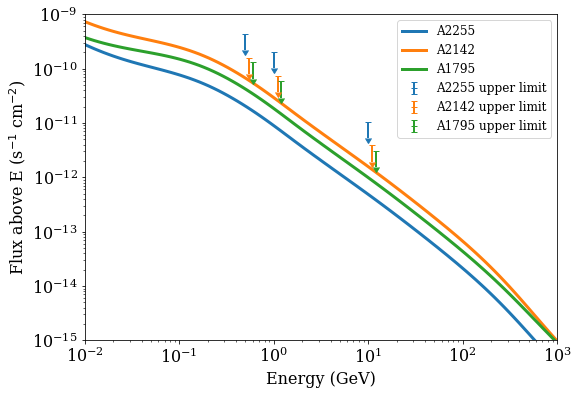

In [5]:
colcycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

E = np.logspace(-2,3,100)*u.GeV

# Data from Fermi paper
Elim = np.array([0.5,1,10])
limit = np.array([[4.4*1e-10, 20.2*1e-11,10.6*1e-12],
                  [1.6*1e-10,7.4*1e-11,3.9*1e-12],
                  [1.3*1e-10,5.8*1e-11,3.1*1e-12]])
names = ['A2255','A2142','A1795']

plt.figure(0,figsize=(8,6))
i = 0
for c in cluster_list:
    F1  = c.get_gamma_flux(Emin=E, Rmax=c.R_truncation)
    F2  = c.get_ic_flux(Emin=E, Rmax=c.R_truncation)
    F = F1+F2
    plt.loglog(E, F, linewidth=3, label=c.name)
    plt.errorbar(Elim*(1+i*0.1), limit[i,:], yerr=0.5*limit[i,:], uplims=True, 
                 marker="_", elinewidth=2, color=colcycle[i],
                 markeredgecolor=colcycle[i], markerfacecolor=colcycle[i],
                 linestyle="None", label=names[i]+' upper limit')
    i = i+1
plt.ylabel('Flux above E (s$^{-1}$ cm$^{-2}$)')
plt.xlabel('Energy (GeV)')
plt.xlim(1e-2,1e3)
plt.ylim(1e-15,1e-9)
plt.legend()
plt.savefig(figdir+'/xcop_integrated_gamma_fermi_obs.pdf')

In [237]:
# Data from Fermi paper
Eexp = np.array([0.5])
Fexp = np.array([0.85*1e-10, 3.45e-10, 3.01*1e-10])
Xexp = np.array([0.011,0.014,0.011])
M500exp = np.array([7.86,14.33,9.87])
names = ['A2255','A2142','A1795']

#---------- Print fluxes
print('----- Standard case')
i=0
for cl in cluster_list:
    c = copy.deepcopy(cl)
    M200 = cluster_global.Mdelta1_to_Mdelta2_NFW(c.M500.to_value('Msun'), delta1=500, delta2=200, c1=3)
    R200 = cluster_global.Mdelta_to_Rdelta(M200, c.redshift, delta=200, cosmo=c.cosmo)
    R500toR200 = R200/c.R500.to_value('kpc')
    print(R500toR200)
    c.X_crp_E = {'X':Xexp[i]*2, 'R_norm':R500toR200*c.R500}
    F1  = c.get_gamma_flux(Emin=Eexp[0]*u.GeV, Rmax=c.R_truncation, Emax=100*u.PeV)
    F2  = c.get_ic_flux(Emin=Eexp[0]*u.GeV, Rmax=c.R_truncation, Emax=100*u.PeV)
    print(c.name, F1+F2, (F1+F2).to_value('cm-2 s-1')/Fexp[i], 
          (F1+F2).to_value('cm-2 s-1')*(1e-14*c.M500.to_value('Msun')/M500exp[i])**(-5/3), 
          (F1+F2).to_value('cm-2 s-1')/Fexp[i]*(1e-14*c.M500.to_value('Msun')/M500exp[i])**(-5/3), 
          M500exp[i]/(1e-14*c.M500.to_value('Msun')))
    i=i+1
print('----- Beta profile')
i=0
for cl in cluster_list:
    c = copy.deepcopy(cl)
    M200 = cluster_global.Mdelta1_to_Mdelta2_NFW(c.M500.to_value('Msun'), delta1=500, delta2=200, c1=3)
    R200 = cluster_global.Mdelta_to_Rdelta(M200, c.redshift, delta=200, cosmo=c.cosmo)
    R500toR200 = R200/c.R500.to_value('kpc')
    print(R500toR200)
    c.X_crp_E = {'X':Xexp[i]*2, 'R_norm':R500toR200*c.R500}
    c.density_gas_model = {'name':'beta', 'n_0':c.beta_model_parameters[0]*u.cm**-3, 'r_c':c.beta_model_parameters[1]*u.kpc, 'beta':c.beta_model_parameters[2]}
    c.set_density_crp_isodens_scal_param(1)
    F1  = c.get_gamma_flux(Emin=Eexp[0]*u.GeV, Rmax=c.R_truncation, Emax=100*u.PeV)
    F2  = c.get_ic_flux(Emin=Eexp[0]*u.GeV, Rmax=c.R_truncation, Emax=100*u.PeV)
    print(c.name, F1+F2, (F1+F2).to_value('cm-2 s-1')/Fexp[i], 
          (F1+F2).to_value('cm-2 s-1')*(1e-14*c.M500.to_value('Msun')/M500exp[i])**(-5/3), 
          (F1+F2).to_value('cm-2 s-1')/Fexp[i]*(1e-14*c.M500.to_value('Msun')/M500exp[i])**(-5/3), 
          M500exp[i]/(1e-14*c.M500.to_value('Msun')))
    i=i+1
print('----- Isothermal 5 keV + constant X')
i=0
for cl in cluster_list:
    c = copy.deepcopy(cl)
    M200 = cluster_global.Mdelta1_to_Mdelta2_NFW(c.M500.to_value('Msun'), delta1=500, delta2=200, c1=3)
    R200 = cluster_global.Mdelta_to_Rdelta(M200, c.redshift, delta=200, cosmo=c.cosmo)
    R500toR200 = R200/c.R500.to_value('kpc')
    print(R500toR200)
    c.X_crp_E = {'X':Xexp[i]*2, 'R_norm':R500toR200*c.R500}
    c.set_density_gas_isoT_param(5*u.keV)
    c.set_density_crp_isobaric_scal_param(1)
    F1  = c.get_gamma_flux(Emin=Eexp[0]*u.GeV, Rmax=c.R_truncation, Emax=100*u.PeV)
    F2  = c.get_ic_flux(Emin=Eexp[0]*u.GeV, Rmax=c.R_truncation, Emax=100*u.PeV)
    print(c.name, F1+F2, (F1+F2).to_value('cm-2 s-1')/Fexp[i], 
          (F1+F2).to_value('cm-2 s-1')*(1e-14*c.M500.to_value('Msun')/M500exp[i])**(-5/3), 
          (F1+F2).to_value('cm-2 s-1')/Fexp[i]*(1e-14*c.M500.to_value('Msun')/M500exp[i])**(-5/3), 
          M500exp[i]/(1e-14*c.M500.to_value('Msun')))
    i=i+1

----- Standard case
1.52123703535
('A2255', <Quantity 3.94907196e-11 1 / (cm2 s)>, 0.46459670136763537, 8.828373702197029e-11, 1.038632200258474, 1.4951777663642072)
1.52123703535
('A2142', <Quantity 1.66881399e-10 1 / (cm2 s)>, 0.48371419998145004, 4.275934637361567e-10, 1.239401344162773, 1.600705963830524)
1.52123703535
('A1795', <Quantity 8.40451646e-11 1 / (cm2 s)>, 0.27921981578665517, 3.826415356814828e-10, 1.271234337812235, 2.1337311109669885)
----- Beta profile
1.52123703535
('A2255', <Quantity 4.18969051e-11 1 / (cm2 s)>, 0.49290476545473255, 9.366290066671773e-11, 1.1019164784319733, 1.4951777663642072)
1.52123703535
('A2142', <Quantity 1.67959239e-10 1 / (cm2 s)>, 0.48683837269887553, 4.3035516854781034e-10, 1.247406285645827, 1.600705963830524)
1.52123703535
('A1795', <Quantity 7.87114397e-11 1 / (cm2 s)>, 0.26149979959650793, 3.583581079877999e-10, 1.1905584982983386, 2.1337311109669885)
----- Isothermal 5 keV + constant X
1.52123703535
('A2255', <Quantity 4.92691378e-11

### Comparison to Radio

### A1795

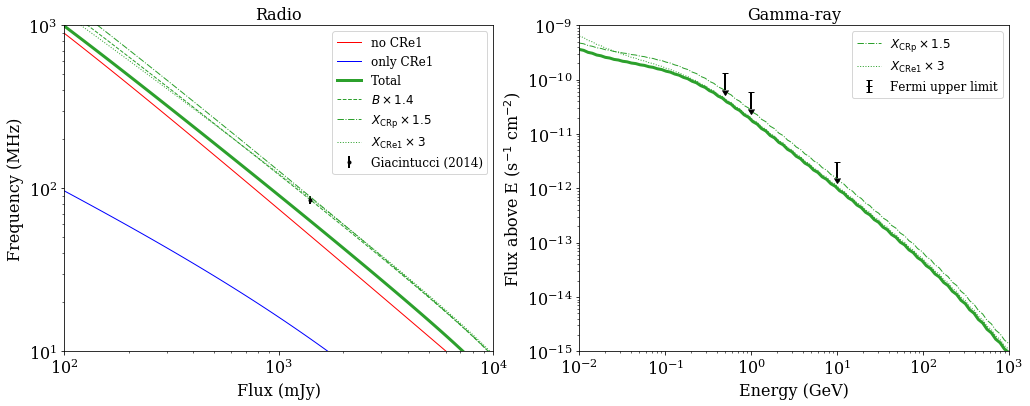

In [313]:
colcycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

nu = np.array([1400])*u.MHz
F = np.array([85.0, 4.9])*u.mJy
R = 100*u.kpc

f = np.logspace(1,4,100)*u.MHz
E = np.logspace(-2,3,100)*u.GeV

plt.figure(0,figsize=(16,6))
plt.subplot(121)
#----- Standard case
ctmp = copy.deepcopy(cluster3)
ctmp.X_cre1_E['X'] = 0
F1  = ctmp.get_synchrotron_spectrum(f, Rmax=R, type_integral='cylindrical')[1]
ctmp = copy.deepcopy(cluster3)
ctmp.X_crp_E['X'] = 0
F2  = ctmp.get_synchrotron_spectrum(f, Rmax=R, type_integral='cylindrical')[1]
ctmp = copy.deepcopy(cluster3)
F3  = ctmp.get_sz_spectrum(f, Rmax=R, type_integral='cylindrical')[1]
plt.loglog(f, F1.to('mJy'), linewidth=1, color='red', label='no CRe1')
plt.loglog(f, F2.to('mJy'), linewidth=1, color='blue', label='only CRe1')
plt.loglog(f, -F3.to('mJy'), linewidth=1, color='grey')
plt.loglog(f, (F1+F2+F3).to('mJy'), linewidth=3, color=colcycle[2], label='Total')
#---------- B field
ctmp = copy.deepcopy(cluster3)
B100 = ctmp.get_magfield_profile(100*u.kpc)[1]
ctmp.set_magfield_isodens_scal_param(B100*1.4, scal=0.5, r0=100*u.kpc)
F1  = ctmp.get_synchrotron_spectrum(f, Rmax=R, type_integral='cylindrical')[1]
F3  = ctmp.get_sz_spectrum(f, Rmax=R, type_integral='cylindrical')[1]
plt.loglog(f, (F1+F3).to('mJy'), linewidth=1, linestyle='--', color=colcycle[2], label=r'$B \times 1.4$')
#---------- XCRp
ctmp = copy.deepcopy(cluster3)
ctmp.X_crp_E['X'] = ctmp.X_crp_E['X']*1.5
F1  = ctmp.get_synchrotron_spectrum(f, Rmax=R, type_integral='cylindrical')[1]
F3  = ctmp.get_sz_spectrum(f, Rmax=R, type_integral='cylindrical')[1]
plt.loglog(f, (F1+F3).to('mJy'), linewidth=1, linestyle='-.', color=colcycle[2], label=r'$X_{\rm CRp} \times 1.5$')
#---------- XCRe1
ctmp = copy.deepcopy(cluster3)
ctmp.X_cre1_E['X'] = ctmp.X_cre1_E['X']*3
F1  = ctmp.get_synchrotron_spectrum(f, Rmax=R, type_integral='cylindrical')[1]
F3  = ctmp.get_sz_spectrum(f, Rmax=R, type_integral='cylindrical')[1]
plt.loglog(f, (F1+F3).to('mJy'), linewidth=1, linestyle=':', color=colcycle[2], label=r'$X_{\rm CRe1} \times 3$')
#---------- Data
plt.errorbar(nu[0].to_value('MHz'), F[0].to_value('mJy'), yerr=F[1].to_value('mJy'), marker=".", elinewidth=2, color='k',linestyle="None", label='Giacintucci (2014)')
plt.ylabel('Frequency (MHz)')
plt.xlabel('Flux (mJy)')
plt.xlim(100,10000)
plt.ylim(10,1e3)
plt.title('Radio')
plt.legend()

plt.subplot(122)
Elim = np.array([0.5,1,10])
limit = np.array([1.3*1e-10,5.8*1e-11,3.1*1e-12])
ctmp = copy.deepcopy(cluster3)
F1  = ctmp.get_gamma_flux(Emin=E, Rmax=c.R_truncation)
F2  = ctmp.get_ic_flux(Emin=E, Rmax=c.R_truncation)
plt.loglog(E, F1+F2, linewidth=3, color=colcycle[2])
#---------- XCRp
ctmp = copy.deepcopy(cluster3)
ctmp.X_crp_E['X'] = ctmp.X_crp_E['X']*1.5
F1  = ctmp.get_gamma_flux(Emin=E, Rmax=c.R_truncation)
F2  = ctmp.get_ic_flux(Emin=E, Rmax=c.R_truncation)
plt.loglog(E, F1+F2, linewidth=1, color=colcycle[2], linestyle='-.', label=r'$X_{\rm CRp} \times 1.5$')
#---------- XCRe
ctmp = copy.deepcopy(cluster3)
ctmp.X_cre1_E['X'] = ctmp.X_cre1_E['X']*3
F1  = ctmp.get_gamma_flux(Emin=E, Rmax=c.R_truncation)
F2  = ctmp.get_ic_flux(Emin=E, Rmax=c.R_truncation)
plt.loglog(E, F1+F2, linewidth=1, color=colcycle[2], linestyle=':', label=r'$X_{\rm CRe1} \times 3$')
plt.errorbar(Elim, limit, yerr=0.5*limit, uplims=True, marker="_", elinewidth=2, color='k',linestyle="None", label='Fermi upper limit')
plt.ylabel('Flux above E (s$^{-1}$ cm$^{-2}$)')
plt.xlabel('Energy (GeV)')
plt.xlim(1e-2,1e3)
plt.ylim(1e-15,1e-9)
plt.title('Gamma-ray')
plt.legend()
plt.savefig(figdir+'/xcop_radio_A1795.pdf')

### A2142

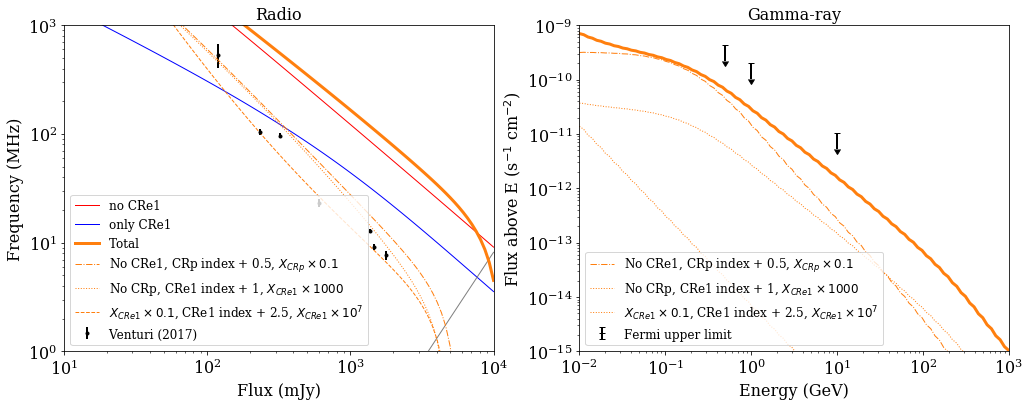

In [349]:
colcycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

nu =      np.array([1778,1465,1377,608,322,234,118])*u.MHz
dat =     np.array([7.7,9.2,12.8,23.3,96.7,103.8,535])*u.mJy
dat_err = np.array([0.7,0.6,0.6,2.0,5.8,6.9,133])*u.mJy
R = 500*u.kpc

f = np.logspace(1,4,100)*u.MHz
E = np.logspace(-2,3,100)*u.GeV

plt.figure(0,figsize=(16,6))
plt.subplot(121)
#----- Standard case
ctmp = copy.deepcopy(cluster2)
ctmp.X_cre1_E['X'] = 0
F1  = ctmp.get_synchrotron_spectrum(f, Rmax=R, type_integral='cylindrical')[1]
ctmp = copy.deepcopy(cluster2)
ctmp.X_crp_E['X'] = 0
F2  = ctmp.get_synchrotron_spectrum(f, Rmax=R, type_integral='cylindrical')[1]
ctmp = copy.deepcopy(cluster2)
F3  = ctmp.get_sz_spectrum(f, Rmax=R, type_integral='cylindrical')[1]
plt.loglog(f, F1.to('mJy'), linewidth=1, color='red', label='no CRe1')
plt.loglog(f, F2.to('mJy'), linewidth=1, color='blue', label='only CRe1')
plt.loglog(f, -F3.to('mJy'), linewidth=1, color='grey')
plt.loglog(f, (F1+F2+F3).to('mJy'), linewidth=3, color=colcycle[1], label='Total')
#---------- XCRp
ctmp = copy.deepcopy(cluster2)
ctmp.X_cre1_E['X'] = 0
ctmp.spectrum_crp_model['Index'] +=0.5
ctmp.X_crp_E['X'] *= 1
F1  = ctmp.get_synchrotron_spectrum(f, Rmax=R, type_integral='cylindrical')[1]
F3  = ctmp.get_sz_spectrum(f, Rmax=R, type_integral='cylindrical')[1]
plt.loglog(f, (F1+F3).to('mJy'), linewidth=1, linestyle='-.', color=colcycle[1], label=r'No CRe1, CRp index + 0.5, $X_{CRp} \times 0.1$')
#---------- XCRe1
ctmp = copy.deepcopy(cluster2)
ctmp.X_crp_E['X'] = 0
ctmp.spectrum_cre1_model['Index'] += 1
ctmp.X_cre1_E['X'] *= 1000
F1  = ctmp.get_synchrotron_spectrum(f, Rmax=R, type_integral='cylindrical')[1]
F3  = ctmp.get_sz_spectrum(f, Rmax=R, type_integral='cylindrical')[1]
plt.loglog(f, (F1+F3).to('mJy'), linewidth=1, linestyle=':', color=colcycle[1], label=r'No CRp, CRe1 index + 1, $X_{CRe1} \times 1000$')
#---------- Mixture
ctmp = copy.deepcopy(cluster2)
ctmp.X_crp_E['X'] *= 0.1
ctmp.spectrum_cre1_model['Index'] += 2.5
ctmp.X_cre1_E['X'] *= 1e7
F1  = ctmp.get_synchrotron_spectrum(f, Rmax=R, type_integral='cylindrical')[1]
F3  = ctmp.get_sz_spectrum(f, Rmax=R, type_integral='cylindrical')[1]
plt.loglog(f, (F1+F3).to('mJy'), linewidth=1, linestyle='--', color=colcycle[1], label=r'$X_{CRe1} \times 0.1$, CRe1 index + 2.5, $X_{CRe1} \times 10^{7}$')


#---------- Data
plt.errorbar(nu.to_value('MHz'), dat.to_value('mJy'), yerr=dat_err.to_value('mJy'), marker=".", elinewidth=2, color='k',linestyle="None", label='Venturi (2017)')
plt.ylabel('Frequency (MHz)')
plt.xlabel('Flux (mJy)')
plt.xlim(10,10000)
plt.ylim(1,1e3)
plt.title('Radio')
plt.legend(loc='lower left')

plt.subplot(122)
Elim = np.array([0.5,1,10])
limit = np.array([4.4*1e-10, 20.2*1e-11,10.6*1e-12])
ctmp = copy.deepcopy(cluster2)
F1  = ctmp.get_gamma_flux(Emin=E, Rmax=c.R_truncation)
F2  = ctmp.get_ic_flux(Emin=E, Rmax=c.R_truncation)
plt.loglog(E, F1+F2, linewidth=3, color=colcycle[1])
#---------- XCRp
ctmp.X_cre1_E['X'] = 0
ctmp.spectrum_crp_model['Index'] +=0.5
ctmp.X_crp_E['X'] *= 1
F1  = ctmp.get_gamma_flux(Emin=E, Rmax=c.R_truncation)
F2  = ctmp.get_ic_flux(Emin=E, Rmax=c.R_truncation)
plt.loglog(E, F1+F2, linewidth=1, color=colcycle[1], linestyle='-.', label=r'No CRe1, CRp index + 0.5, $X_{CRp} \times 0.1$')
#---------- XCRe
ctmp = copy.deepcopy(cluster2)
ctmp.X_crp_E['X'] = 0
ctmp.spectrum_cre1_model['Index'] += 1
ctmp.X_cre1_E['X'] *= 1000
F1  = ctmp.get_gamma_flux(Emin=E, Rmax=c.R_truncation)
F2  = ctmp.get_ic_flux(Emin=E, Rmax=c.R_truncation)
plt.loglog(E, F1+F2, linewidth=1, color=colcycle[1], linestyle=':', label=r'No CRp, CRe1 index + 1, $X_{CRe1} \times 1000$')
#---------- Mixture
ctmp = copy.deepcopy(cluster2)
ctmp.X_crp_E['X'] *= 0.1
ctmp.spectrum_cre1_model['Index'] += 2.5
ctmp.X_cre1_E['X'] *= 1e7
F1  = ctmp.get_gamma_flux(Emin=E, Rmax=c.R_truncation)
F2  = ctmp.get_ic_flux(Emin=E, Rmax=c.R_truncation)
plt.loglog(E, F1+F2, linewidth=1, color=colcycle[1], linestyle=':', label=r'$X_{CRe1} \times 0.1$, CRe1 index + 2.5, $X_{CRe1} \times 10^{7}$')
plt.errorbar(Elim, limit, yerr=0.5*limit, uplims=True, marker="_", elinewidth=2, color='k',linestyle="None", label='Fermi upper limit')
plt.ylabel('Flux above E (s$^{-1}$ cm$^{-2}$)')
plt.xlabel('Energy (GeV)')
plt.xlim(1e-2,1e3)
plt.ylim(1e-15,1e-9)
plt.title('Gamma-ray')
plt.legend(loc='lower left')
plt.savefig(figdir+'/xcop_radio_A2142.pdf')

### A2255

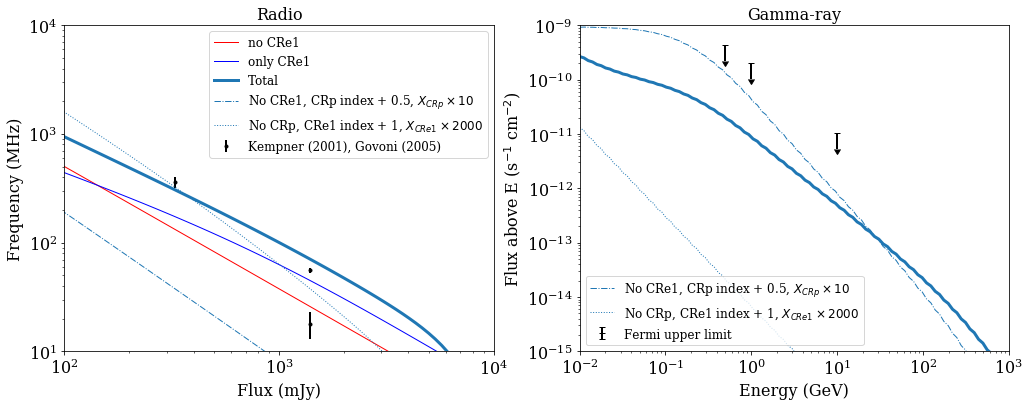

In [334]:
colcycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

nu = np.array([327, 1400, 1400])*u.MHz
dat = np.array([360, 18, 56.0])*u.mJy
dat_err = np.array([44, 5, 3])*u.mJy
R = 930*u.kpc

f = np.logspace(1,4,100)*u.MHz
E = np.logspace(-2,3,100)*u.GeV

plt.figure(0,figsize=(16,6))
plt.subplot(121)
#----- Standard case
ctmp = copy.deepcopy(cluster1)
ctmp.X_cre1_E['X'] = 0
F1  = ctmp.get_synchrotron_spectrum(f, Rmax=R, type_integral='cylindrical')[1]
ctmp = copy.deepcopy(cluster1)
ctmp.X_crp_E['X'] = 0
F2  = ctmp.get_synchrotron_spectrum(f, Rmax=R, type_integral='cylindrical')[1]
ctmp = copy.deepcopy(cluster1)
F3  = ctmp.get_sz_spectrum(f, Rmax=R, type_integral='cylindrical')[1]
plt.loglog(f, F1.to('mJy'), linewidth=1, color='red', label='no CRe1')
plt.loglog(f, F2.to('mJy'), linewidth=1, color='blue', label='only CRe1')
plt.loglog(f, -F3.to('mJy'), linewidth=1, color='grey')
plt.loglog(f, (F1+F2+F3).to('mJy'), linewidth=3, color=colcycle[0], label='Total')
#---------- XCRp
ctmp = copy.deepcopy(cluster1)
ctmp.X_cre1_E['X'] = 0
ctmp.spectrum_crp_model['Index'] +=0.5
ctmp.X_crp_E['X'] *= 1
F1  = ctmp.get_synchrotron_spectrum(f, Rmax=R, type_integral='cylindrical')[1]
F3  = ctmp.get_sz_spectrum(f, Rmax=R, type_integral='cylindrical')[1]
plt.loglog(f, (F1+F3).to('mJy'), linewidth=1, linestyle='-.', color=colcycle[0], label=r'No CRe1, CRp index + 0.5, $X_{CRp} \times 10$')
#---------- XCRe1
ctmp = copy.deepcopy(cluster1)
ctmp.X_crp_E['X'] = 0
ctmp.spectrum_cre1_model['Index'] += 1
ctmp.X_cre1_E['X'] *= 2000
F1  = ctmp.get_synchrotron_spectrum(f, Rmax=R, type_integral='cylindrical')[1]
F3  = ctmp.get_sz_spectrum(f, Rmax=R, type_integral='cylindrical')[1]
plt.loglog(f, (F1+F3).to('mJy'), linewidth=1, linestyle=':', color=colcycle[0], label=r'No CRp, CRe1 index + 1, $X_{CRe1} \times 2000$')
#---------- Data
plt.errorbar(nu.to_value('MHz'), dat.to_value('mJy'), yerr=dat_err.to_value('mJy'), marker=".", elinewidth=2, color='k',linestyle="None", label='Kempner (2001), Govoni (2005)')
plt.ylabel('Frequency (MHz)')
plt.xlabel('Flux (mJy)')
plt.xlim(100,10000)
plt.ylim(10,1e4)
plt.title('Radio')
plt.legend(loc='upper right')

plt.subplot(122)
Elim = np.array([0.5,1,10])
limit = np.array([4.4*1e-10, 20.2*1e-11,10.6*1e-12])
ctmp = copy.deepcopy(cluster1)
F1  = ctmp.get_gamma_flux(Emin=E, Rmax=c.R_truncation)
F2  = ctmp.get_ic_flux(Emin=E, Rmax=c.R_truncation)
plt.loglog(E, F1+F2, linewidth=3, color=colcycle[0])
#---------- XCRp
ctmp.X_cre1_E['X'] = 0
ctmp.spectrum_crp_model['Index'] +=0.5
ctmp.X_crp_E['X'] *= 10
F1  = ctmp.get_gamma_flux(Emin=E, Rmax=c.R_truncation)
F2  = ctmp.get_ic_flux(Emin=E, Rmax=c.R_truncation)
plt.loglog(E, F1+F2, linewidth=1, color=colcycle[0], linestyle='-.', label=r'No CRe1, CRp index + 0.5, $X_{CRp} \times 10$')
#---------- XCRe
ctmp = copy.deepcopy(cluster1)
ctmp.X_crp_E['X'] = 0
ctmp.spectrum_cre1_model['Index'] += 1
ctmp.X_cre1_E['X'] *= 2000
F1  = ctmp.get_gamma_flux(Emin=E, Rmax=c.R_truncation)
F2  = ctmp.get_ic_flux(Emin=E, Rmax=c.R_truncation)
plt.loglog(E, F1+F2, linewidth=1, color=colcycle[0], linestyle=':', label=r'No CRp, CRe1 index + 1, $X_{CRe1} \times 2000$')
plt.errorbar(Elim, limit, yerr=0.5*limit, uplims=True, marker="_", elinewidth=2, color='k',linestyle="None", label='Fermi upper limit')
plt.ylabel('Flux above E (s$^{-1}$ cm$^{-2}$)')
plt.xlabel('Energy (GeV)')
plt.xlim(1e-2,1e3)
plt.ylim(1e-15,1e-9)
plt.title('Gamma-ray')
plt.legend(loc='lower left')
plt.savefig(figdir+'/xcop_radio_A2255.pdf')